<a href="https://colab.research.google.com/github/Yutong-Lu/Datathon-4/blob/main/Pourya_NeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Yutong-Lu/Datathon-4.git

Cloning into 'Datathon-4'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 56 (delta 23), reused 21 (delta 6), pack-reused 0
Receiving objects: 100% (56/56), 15.61 MiB | 9.47 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
cd ./Datathon-4

/content/Datathon-4


In [ ]:
import pandas as pd
import io
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold

In [ ]:
def get_dataframe(name):
    df = pd.read_csv(f'{name}.csv')
    return df

In [ ]:
name = 'datathon4'
df = get_dataframe(name)
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [ ]:
df.isna().sum()

encounter_id                      0
patient_id                        0
hospital_id                       0
hospital_death                    0
age                            4228
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 186, dtype: int64

In [ ]:
print(df.shape)
df = df.dropna(axis=1, thresh=df.shape[0] * (3/4))
print(df.shape)

(91713, 186)
(91713, 112)


In [ ]:
print(df.columns.tolist())

['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bun_apache', 'creatinine_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_non

#Preparing train, validation, and test sets

Based on the descriptions of the columns, 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' both provide probabilistic predictions of mortality. Since they have a high correlation, we can combine them into a single target column for our mortality prediction neural network.

In [ ]:
df['mortality_prob'] = df[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].mean(axis=1)
df = df.drop(['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], axis=1)

In [ ]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

df['mortality_prob'] = pd.cut(df['mortality_prob'], bins=bins, labels=labels)

In [ ]:
df = df.drop(['encounter_id', 'patient_id', 'hospital_id','icu_id'], axis=1)

### encoding non-numerical data
According to the below cell, we have identified that our non-numerical columns have limited number of values, suggesting that they are categorical variables. Categorical variables are those that can be divided into distinct categories. In many machine learning algorithms, these variables need to be converted into numerical form. This process is known as encoding. Encoding categorical variables can help improve the performance of machine learning algorithms by converting non-numerical data into numerical data that can be provided to ML algorithms to generate accurate prediction

In [ ]:
df = df.dropna()
print(df.shape)

(26629, 107)


In [ ]:
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_numeric_columns)

unique_values = df[non_numeric_columns].nunique()
print(unique_values)

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'mortality_prob']
ethnicity                 6
gender                    2
hospital_admit_source    15
icu_admit_source          5
icu_stay_type             3
icu_type                  8
apache_3j_bodysystem     11
apache_2_bodysystem      10
mortality_prob           10
dtype: int64


In [ ]:
le = LabelEncoder()

# Apply Label Encoding to each categorical column
df_encoded = df.copy()
for column in non_numeric_columns:
    df_encoded[column] = le.fit_transform(df_encoded[column])

# Check that the Label Encoding has worked properly

unique_values = df_encoded[non_numeric_columns].nunique()
print(unique_values)

non_numeric_columns = df_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
print(non_numeric_columns)

ethnicity                 6
gender                    2
hospital_admit_source    15
icu_admit_source          5
icu_stay_type             3
icu_type                  8
apache_3j_bodysystem     11
apache_2_bodysystem      10
mortality_prob           10
dtype: int64
[]


# Feature selection

### 1. Using Variance Threshold

Variance Threshold is a feature selection method that works by eliminating features with very low variance, i.e., features with not much useful information. This method is useful when you want to reduce the dimensionality of the dataset without losing too much information. The idea behind Variance Threshold is that when a feature doesn't vary much within itself, it generally has very little predictive power. Therefore, features with a variance below a certain threshold are considered uninformative and are removed from the dataset.

In [ ]:
selector = VarianceThreshold(threshold = 0)

In [ ]:
selector.fit(df_encoded)

VarianceThreshold(threshold=0)

In [ ]:
mask = selector.get_support()
df_encoded_variance_threshold = df_encoded.loc[:, mask]

df_encoded_variance_threshold.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,mortality_prob
0,0,68.0,22.730000,0,2,1,180.3,4,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9,0,0
1,0,77.0,27.420000,0,2,0,160.0,4,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8,6,3
5,0,67.0,27.560000,0,2,1,190.5,2,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7,4,0
17,0,46.0,25.845717,0,3,1,167.6,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6,0
23,0,87.0,21.963763,0,2,1,180.3,4,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0,2


### 2. Removing multicollinearity
Multicollinearity is a situation in which two or more independent variables in a multiple regression model are highly linearly related, meaning they contain similar information about the variance within the dataset. When independent variables are correlated, it can cause problems in the interpretation of the model coefficients, as it undermines the statistical significance of the independent variables. The presence of multicollinearity can lead to an inflated standard error, which can make it difficult to accurately determine which predictors are significantly related to the response variable. It can also lead to unstable estimates of the regression coefficients, which can cause the estimated coefficients to change significantly depending on the subset of the data used. Therefore, it is often beneficial to remove multicollinearity from a dataset before training a machine learning model.

We have used a correlation matrix to identify pairs of variables that have a correlation greater than 0.9. We have then removed the variables from your dataset that are part of these pairs.

First we separate the features (X) and target (y) from the DataFrame

In [ ]:
from sklearn.model_selection import train_test_split

X = df_encoded_variance_threshold.drop('mortality_prob', axis=1)
y = df_encoded_variance_threshold['mortality_prob']

print(X.shape, y.shape)

(26629, 104) (26629,)


<AxesSubplot:>

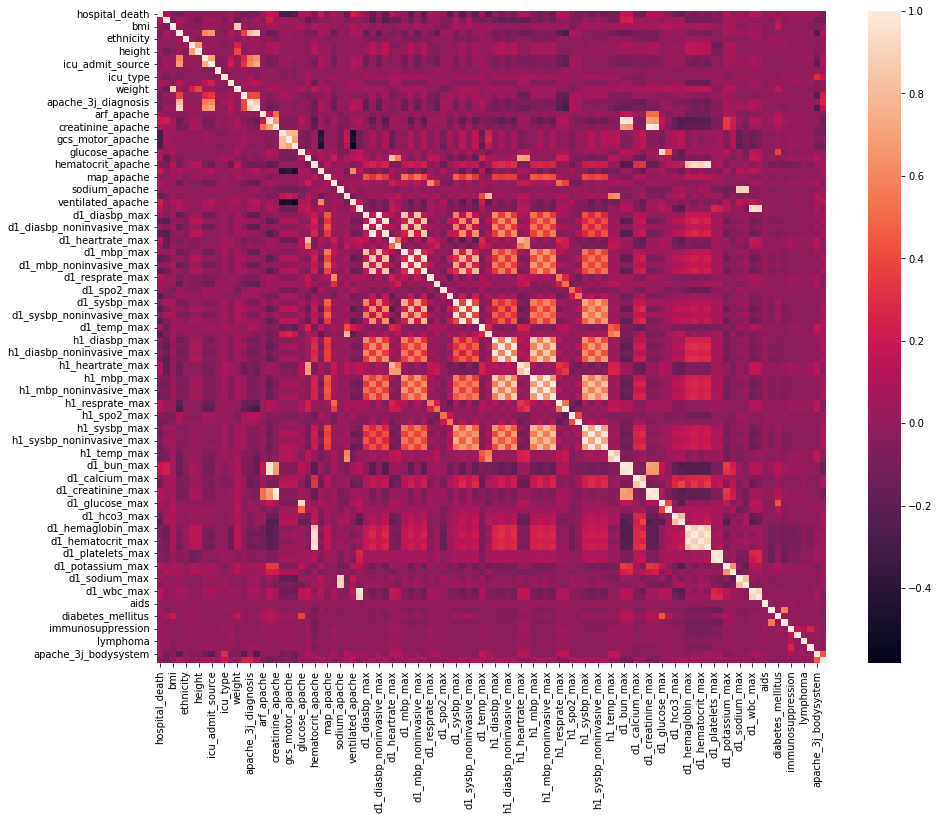

In [ ]:
#Plotting the correlation heatmap
correlation_matrix = X.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix)

In [ ]:
multicollinear_cols = set()

for i in range (len(correlation_matrix.columns)):
  for j in range(i):
    if abs(correlation_matrix.iloc[i,j]) > 0.7:
      multicollinear_cols.add(correlation_matrix.columns[i])

print(len(multicollinear_cols))

47


In [ ]:
X.drop(labels=multicollinear_cols, axis = 1, inplace=True)

In [ ]:
X.shape

(26629, 57)

Now we split them into train, validation, and test sets.

In [ ]:
# Split the features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

In [ ]:
# Create the RFECV object for regression
cv = KFold(n_splits=5)
rfr = RandomForestRegressor()
rfecv = RFECV(estimator=rfr, cv=cv, step=1)
rfecv.fit(X_train, y_train)

# Get the selected features
rfecv_features_regression = X_train.columns[rfecv.get_support()]

print(rfecv_features_regression)

Index(['patient_id', 'hospital_death', 'age', 'hospital_admit_source',
       'icu_id', 'icu_stay_type', 'pre_icu_los_days', 'apache_2_diagnosis',
       'bun_apache', 'creatinine_apache', 'gcs_eyes_apache', 'glucose_apache',
       'heart_rate_apache', 'hematocrit_apache', 'map_apache',
       'resprate_apache', 'temp_apache', 'wbc_apache'],
      dtype='object')


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

# Backward Feature Elimination
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=40), n_features_to_select=30, direction='backward')
sfs.fit(X_train, y_train)

# Get the selected features
backward_features = X_train.columns[sfs.get_support()]

print(backward_features)

Index(['hospital_id', 'hospital_death', 'age', 'elective_surgery',
       'hospital_admit_source', 'icu_id', 'icu_stay_type', 'icu_type',
       'pre_icu_los_days', 'bun_apache', 'gcs_eyes_apache',
       'heart_rate_apache', 'hematocrit_apache', 'intubated_apache',
       'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache',
       'd1_resprate_max', 'd1_spo2_max', 'h1_diasbp_max', 'h1_spo2_max',
       'h1_spo2_min', 'd1_potassium_max', 'cirrhosis', 'diabetes_mellitus',
       'hepatic_failure', 'leukemia', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')


In [ ]:
rfecv_features_regression = ['patient_id', 'hospital_death', 'age', 'hospital_admit_source',
       'icu_id', 'icu_stay_type', 'pre_icu_los_days', 'apache_2_diagnosis',
       'bun_apache', 'creatinine_apache', 'gcs_eyes_apache', 'glucose_apache',
       'heart_rate_apache', 'hematocrit_apache', 'map_apache',
       'resprate_apache', 'temp_apache', 'wbc_apache']

#Removing 'encounter_id', 'patient_id', 'hospital_id','icu_id'
to_be_removed = ['encounter_id', 'patient_id', 'hospital_id','icu_id']
features = [i for i in rfecv_features_regression if i not in to_be_removed]

In [ ]:
backward_features = ['hospital_id', 'hospital_death', 'age', 'elective_surgery',
       'hospital_admit_source', 'icu_id', 'icu_stay_type', 'icu_type',
       'pre_icu_los_days', 'bun_apache', 'gcs_eyes_apache',
       'heart_rate_apache', 'hematocrit_apache', 'intubated_apache',
       'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache',
       'd1_resprate_max', 'd1_spo2_max', 'h1_diasbp_max', 'h1_spo2_max',
       'h1_spo2_min', 'd1_potassium_max', 'cirrhosis', 'diabetes_mellitus',
       'hepatic_failure', 'leukemia', 'apache_3j_bodysystem',
       'apache_2_bodysystem']

to_be_removed = ['encounter_id', 'patient_id', 'hospital_id','icu_id']
features = [i for i in backward_features if i not in to_be_removed]

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Create the RFECV object for regression
cv = KFold(n_splits=5)
rfr = RandomForestRegressor()
rfecv = RFECV(estimator=rfr, cv=cv, step=1)
rfecv.fit(X_train_scaled, y_train)

# Get the selected features
rfecv_features_regression = X_train.columns[rfecv.get_support()]

print(rfecv_features_regression)

Index(['hospital_death', 'age', 'bmi', 'hospital_admit_source',
       'icu_stay_type', 'pre_icu_los_days', 'apache_2_diagnosis', 'bun_apache',
       'creatinine_apache', 'gcs_eyes_apache', 'glucose_apache',
       'heart_rate_apache', 'intubated_apache', 'map_apache',
       'resprate_apache', 'temp_apache', 'wbc_apache', 'd1_diasbp_min',
       'd1_platelets_max'],
      dtype='object')


In [ ]:
# Create the RFECV object for regression
cv = KFold(n_splits=10)
rfr = RandomForestRegressor()
rfecv = RFECV(estimator=rfr, cv=cv, step=1)
rfecv.fit(X_train_scaled, y_train)

# Get the selected features
rfecv_features_regression = X_train.columns[rfecv.get_support()]

print(rfecv_features_regression)

Index(['hospital_death', 'age', 'bmi', 'hospital_admit_source',
       'icu_stay_type', 'pre_icu_los_days', 'apache_2_diagnosis', 'bun_apache',
       'creatinine_apache', 'gcs_eyes_apache', 'glucose_apache',
       'heart_rate_apache', 'hematocrit_apache', 'intubated_apache',
       'map_apache', 'resprate_apache', 'temp_apache', 'wbc_apache',
       'h1_diasbp_min', 'd1_glucose_min', 'd1_platelets_max'],
      dtype='object')


In [ ]:
features = ['age', 'bmi', 'hospital_admit_source',
       'icu_stay_type', 'pre_icu_los_days', 'apache_2_diagnosis', 'bun_apache',
       'creatinine_apache', 'gcs_eyes_apache', 'glucose_apache',
       'heart_rate_apache', 'intubated_apache', 'map_apache',
       'resprate_apache', 'temp_apache', 'wbc_apache', 'd1_diasbp_min',
       'd1_platelets_max']

In [ ]:
X_test_binary = X_test['hospital_death']

X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the neural network
class Net(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 100)
        self.fc4 = nn.Linear(100, 50)
        self.bn4 = nn.BatchNorm1d(50)
        self.dropout4 = nn.Dropout(0.5)
        self.fc9 = nn.Linear(50, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn4(self.fc4(torch.relu(x)))
        x = self.dropout4(torch.relu(x))
        x = self.fc9(torch.relu(x))
        x = self.softmax(x)
        return x


# Create the neural network
input_size = X_train.shape[1]
hidden_size = 64
model = Net(input_size, hidden_size)

# Move the neural network to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Convert the data to PyTorch tensors and move them to GPU
X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
y_train_tensor = torch.from_numpy(y_train.values).to(device)
X_val_tensor = torch.from_numpy(X_val.values).float().to(device)
y_val_tensor = torch.from_numpy(y_val.values).to(device)
X_test_tensor = torch.from_numpy(X_test.values).float().to(device)
y_test_tensor = torch.from_numpy(y_test.values).to(device)

# Create the DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Lists to store the training and validation losses
train_losses = []
val_losses = []
best_val_loss = float('inf')

# Initialize the best model parameters to None
best_model_params = None


# Train the neural network
for epoch in range(500):
    model.train()
    train_loss = 0
    for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/100'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validate the neural network
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    print(f'Epoch {epoch+1}/100, training loss: {train_loss / len(train_loader)}, validation loss: {val_loss / len(val_loader)}')

    if val_loss / len(val_loader) < best_val_loss:
        best_val_loss = val_loss / len(val_loader)
        best_model_params = model.state_dict()

Epoch 1/100:   0%|          | 0/533 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 533/533 [00:02<00:00, 197.39it/s]


Epoch 1/100, training loss: 1.890106044164518, validation loss: 1.7458505443672636


Epoch 2/100: 100%|██████████| 533/533 [00:02<00:00, 233.89it/s]


Epoch 2/100, training loss: 1.7439684259511292, validation loss: 1.7432411962480687


Epoch 3/100: 100%|██████████| 533/533 [00:02<00:00, 238.50it/s]


Epoch 3/100, training loss: 1.740039548551835, validation loss: 1.7431298423169264


Epoch 4/100: 100%|██████████| 533/533 [00:02<00:00, 239.27it/s]


Epoch 4/100, training loss: 1.7387820509092893, validation loss: 1.7430195274637705


Epoch 5/100: 100%|██████████| 533/533 [00:02<00:00, 222.83it/s]


Epoch 5/100, training loss: 1.737059613553489, validation loss: 1.7405910723244966


Epoch 6/100: 100%|██████████| 533/533 [00:02<00:00, 240.04it/s]


Epoch 6/100, training loss: 1.7353026010305752, validation loss: 1.7398995000924637


Epoch 7/100: 100%|██████████| 533/533 [00:02<00:00, 239.37it/s]


Epoch 7/100, training loss: 1.734704089880437, validation loss: 1.7381804425324967


Epoch 8/100: 100%|██████████| 533/533 [00:02<00:00, 230.19it/s]


Epoch 8/100, training loss: 1.7327232047719758, validation loss: 1.7379399831615276


Epoch 9/100: 100%|██████████| 533/533 [00:02<00:00, 239.22it/s]


Epoch 9/100, training loss: 1.7332781383288958, validation loss: 1.7381472294010334


Epoch 10/100: 100%|██████████| 533/533 [00:02<00:00, 206.47it/s]


Epoch 10/100, training loss: 1.7323222039564465, validation loss: 1.7378925227407198


Epoch 11/100: 100%|██████████| 533/533 [00:02<00:00, 210.88it/s]


Epoch 11/100, training loss: 1.7311780454964842, validation loss: 1.736533873116792


Epoch 12/100: 100%|██████████| 533/533 [00:02<00:00, 239.71it/s]


Epoch 12/100, training loss: 1.7317311895721177, validation loss: 1.737019884942183


Epoch 13/100: 100%|██████████| 533/533 [00:02<00:00, 237.67it/s]


Epoch 13/100, training loss: 1.7308517759333855, validation loss: 1.7365609104953594


Epoch 14/100: 100%|██████████| 533/533 [00:02<00:00, 238.74it/s]


Epoch 14/100, training loss: 1.7300279916562908, validation loss: 1.7356955542493222


Epoch 15/100: 100%|██████████| 533/533 [00:02<00:00, 225.30it/s]


Epoch 15/100, training loss: 1.729728808769813, validation loss: 1.7355453167388688


Epoch 16/100: 100%|██████████| 533/533 [00:02<00:00, 240.08it/s]


Epoch 16/100, training loss: 1.728050864659823, validation loss: 1.7345952427209312


Epoch 17/100: 100%|██████████| 533/533 [00:02<00:00, 227.13it/s]


Epoch 17/100, training loss: 1.7275370486905381, validation loss: 1.7380223025136918


Epoch 18/100: 100%|██████████| 533/533 [00:02<00:00, 233.58it/s]


Epoch 18/100, training loss: 1.7265238840181876, validation loss: 1.735703213001365


Epoch 19/100: 100%|██████████| 533/533 [00:02<00:00, 237.12it/s]


Epoch 19/100, training loss: 1.7268186505695222, validation loss: 1.7342087252816158


Epoch 20/100: 100%|██████████| 533/533 [00:02<00:00, 233.67it/s]


Epoch 20/100, training loss: 1.7261661785404856, validation loss: 1.7343495683883554


Epoch 21/100: 100%|██████████| 533/533 [00:02<00:00, 228.54it/s]


Epoch 21/100, training loss: 1.7238688929666945, validation loss: 1.7368702328027184


Epoch 22/100: 100%|██████████| 533/533 [00:02<00:00, 211.01it/s]


Epoch 22/100, training loss: 1.7256646001987566, validation loss: 1.7346528919775095


Epoch 23/100: 100%|██████████| 533/533 [00:02<00:00, 236.10it/s]


Epoch 23/100, training loss: 1.724463791382022, validation loss: 1.7326687271915264


Epoch 24/100: 100%|██████████| 533/533 [00:02<00:00, 232.83it/s]


Epoch 24/100, training loss: 1.7232893029923286, validation loss: 1.733878254890442


Epoch 25/100: 100%|██████████| 533/533 [00:02<00:00, 216.65it/s]


Epoch 25/100, training loss: 1.7237238450077192, validation loss: 1.7331850991320255


Epoch 26/100: 100%|██████████| 533/533 [00:02<00:00, 193.21it/s]


Epoch 26/100, training loss: 1.7213739058313853, validation loss: 1.7331810646982335


Epoch 27/100: 100%|██████████| 533/533 [00:02<00:00, 180.33it/s]


Epoch 27/100, training loss: 1.722071479677483, validation loss: 1.732325388424432


Epoch 28/100: 100%|██████████| 533/533 [00:02<00:00, 211.32it/s]


Epoch 28/100, training loss: 1.7217153013311677, validation loss: 1.7330134172937763


Epoch 29/100: 100%|██████████| 533/533 [00:02<00:00, 219.24it/s]


Epoch 29/100, training loss: 1.7220273910275543, validation loss: 1.7314989157577059


Epoch 30/100: 100%|██████████| 533/533 [00:02<00:00, 237.91it/s]


Epoch 30/100, training loss: 1.722492073982339, validation loss: 1.73256794641267


Epoch 31/100: 100%|██████████| 533/533 [00:02<00:00, 215.04it/s]


Epoch 31/100, training loss: 1.7218907158996553, validation loss: 1.7321153149675967


Epoch 32/100: 100%|██████████| 533/533 [00:02<00:00, 223.14it/s]


Epoch 32/100, training loss: 1.7203578591123083, validation loss: 1.731546579901852


Epoch 33/100: 100%|██████████| 533/533 [00:02<00:00, 192.29it/s]


Epoch 33/100, training loss: 1.7192593484166416, validation loss: 1.7311807950930809


Epoch 34/100: 100%|██████████| 533/533 [00:02<00:00, 221.23it/s]


Epoch 34/100, training loss: 1.719646611088436, validation loss: 1.7293242883326403


Epoch 35/100: 100%|██████████| 533/533 [00:02<00:00, 205.59it/s]


Epoch 35/100, training loss: 1.718815511207867, validation loss: 1.7294225399173908


Epoch 36/100: 100%|██████████| 533/533 [00:03<00:00, 177.50it/s]


Epoch 36/100, training loss: 1.7171556390472469, validation loss: 1.7291448997027838


Epoch 37/100: 100%|██████████| 533/533 [00:02<00:00, 220.46it/s]


Epoch 37/100, training loss: 1.7189809444026696, validation loss: 1.7296600243938502


Epoch 38/100: 100%|██████████| 533/533 [00:02<00:00, 221.39it/s]


Epoch 38/100, training loss: 1.7153029450779784, validation loss: 1.7265734574688014


Epoch 39/100: 100%|██████████| 533/533 [00:02<00:00, 241.25it/s]


Epoch 39/100, training loss: 1.7182993280507386, validation loss: 1.725952432226779


Epoch 40/100: 100%|██████████| 533/533 [00:02<00:00, 243.49it/s]


Epoch 40/100, training loss: 1.7161585376589203, validation loss: 1.7301750334341135


Epoch 41/100: 100%|██████████| 533/533 [00:02<00:00, 239.60it/s]


Epoch 41/100, training loss: 1.7167795518549478, validation loss: 1.7248698152712922


Epoch 42/100: 100%|██████████| 533/533 [00:01<00:00, 277.75it/s]


Epoch 42/100, training loss: 1.7164476821391266, validation loss: 1.7266076447358771


Epoch 43/100: 100%|██████████| 533/533 [00:01<00:00, 277.17it/s]


Epoch 43/100, training loss: 1.7151351760073406, validation loss: 1.726197871699262


Epoch 44/100: 100%|██████████| 533/533 [00:01<00:00, 282.44it/s]


Epoch 44/100, training loss: 1.7156715142570338, validation loss: 1.7256154747151617


Epoch 45/100: 100%|██████████| 533/533 [00:01<00:00, 277.15it/s]


Epoch 45/100, training loss: 1.715456493576293, validation loss: 1.7251753255502502


Epoch 46/100: 100%|██████████| 533/533 [00:01<00:00, 280.97it/s]


Epoch 46/100, training loss: 1.7145955772829324, validation loss: 1.7270924502344274


Epoch 47/100: 100%|██████████| 533/533 [00:01<00:00, 275.64it/s]


Epoch 47/100, training loss: 1.71375856457687, validation loss: 1.7270020726901383


Epoch 48/100: 100%|██████████| 533/533 [00:01<00:00, 278.11it/s]


Epoch 48/100, training loss: 1.7142600187888513, validation loss: 1.7274703161040348


Epoch 49/100: 100%|██████████| 533/533 [00:01<00:00, 273.71it/s]


Epoch 49/100, training loss: 1.7140200008370863, validation loss: 1.7262556686330197


Epoch 50/100: 100%|██████████| 533/533 [00:01<00:00, 282.75it/s]


Epoch 50/100, training loss: 1.7159264004923838, validation loss: 1.7246175203750382


Epoch 51/100: 100%|██████████| 533/533 [00:01<00:00, 274.52it/s]


Epoch 51/100, training loss: 1.7146245312735466, validation loss: 1.7261067059502673


Epoch 52/100: 100%|██████████| 533/533 [00:01<00:00, 276.48it/s]


Epoch 52/100, training loss: 1.7139579028618046, validation loss: 1.7236402613013537


Epoch 53/100: 100%|██████████| 533/533 [00:01<00:00, 279.35it/s]


Epoch 53/100, training loss: 1.7140575743526723, validation loss: 1.7261406663638443


Epoch 54/100: 100%|██████████| 533/533 [00:01<00:00, 269.86it/s]


Epoch 54/100, training loss: 1.713901888138805, validation loss: 1.727537946914559


Epoch 55/100: 100%|██████████| 533/533 [00:02<00:00, 207.09it/s]


Epoch 55/100, training loss: 1.7138063390975151, validation loss: 1.7264007196497562


Epoch 56/100: 100%|██████████| 533/533 [00:02<00:00, 221.89it/s]


Epoch 56/100, training loss: 1.7132315107850151, validation loss: 1.7234941027057704


Epoch 57/100: 100%|██████████| 533/533 [00:02<00:00, 223.32it/s]


Epoch 57/100, training loss: 1.7128853115758127, validation loss: 1.7270755785614698


Epoch 58/100: 100%|██████████| 533/533 [00:02<00:00, 249.30it/s]


Epoch 58/100, training loss: 1.7118834178845834, validation loss: 1.7268866745393667


Epoch 59/100: 100%|██████████| 533/533 [00:02<00:00, 245.58it/s]


Epoch 59/100, training loss: 1.711129725762201, validation loss: 1.725482302815167


Epoch 60/100: 100%|██████████| 533/533 [00:02<00:00, 260.69it/s]


Epoch 60/100, training loss: 1.7103885577722517, validation loss: 1.7256963511011494


Epoch 61/100: 100%|██████████| 533/533 [00:02<00:00, 255.27it/s]


Epoch 61/100, training loss: 1.7124264660740436, validation loss: 1.725650066760049


Epoch 62/100: 100%|██████████| 533/533 [00:02<00:00, 245.07it/s]


Epoch 62/100, training loss: 1.7122379894775477, validation loss: 1.726830162219147


Epoch 63/100: 100%|██████████| 533/533 [00:02<00:00, 257.45it/s]


Epoch 63/100, training loss: 1.7107808903055388, validation loss: 1.723264105284392


Epoch 64/100: 100%|██████████| 533/533 [00:02<00:00, 245.15it/s]


Epoch 64/100, training loss: 1.7108084480042305, validation loss: 1.7248379392410391


Epoch 65/100: 100%|██████████| 533/533 [00:02<00:00, 240.65it/s]


Epoch 65/100, training loss: 1.7120546113706663, validation loss: 1.7235942607495323


Epoch 66/100: 100%|██████████| 533/533 [00:02<00:00, 236.87it/s]


Epoch 66/100, training loss: 1.710872593561212, validation loss: 1.724890117325


Epoch 67/100: 100%|██████████| 533/533 [00:02<00:00, 249.55it/s]


Epoch 67/100, training loss: 1.7108345154749742, validation loss: 1.7238959865783579


Epoch 68/100: 100%|██████████| 533/533 [00:02<00:00, 257.60it/s]


Epoch 68/100, training loss: 1.7115530144653892, validation loss: 1.7250311863956167


Epoch 69/100: 100%|██████████| 533/533 [00:02<00:00, 232.43it/s]


Epoch 69/100, training loss: 1.7101682026435465, validation loss: 1.7276836135494176


Epoch 70/100: 100%|██████████| 533/533 [00:02<00:00, 225.52it/s]


Epoch 70/100, training loss: 1.7110352878498987, validation loss: 1.722080466462605


Epoch 71/100: 100%|██████████| 533/533 [00:02<00:00, 232.10it/s]


Epoch 71/100, training loss: 1.710306752689784, validation loss: 1.7254581602651682


Epoch 72/100: 100%|██████████| 533/533 [00:02<00:00, 208.74it/s]


Epoch 72/100, training loss: 1.7100659051934506, validation loss: 1.7217153453115206


Epoch 73/100: 100%|██████████| 533/533 [00:02<00:00, 213.81it/s]


Epoch 73/100, training loss: 1.7103196389232298, validation loss: 1.7276097402643802


Epoch 74/100: 100%|██████████| 533/533 [00:02<00:00, 214.47it/s]


Epoch 74/100, training loss: 1.709071151534791, validation loss: 1.7210886567386228


Epoch 75/100: 100%|██████████| 533/533 [00:02<00:00, 229.51it/s]


Epoch 75/100, training loss: 1.7104120118085708, validation loss: 1.7237473076848842


Epoch 76/100: 100%|██████████| 533/533 [00:02<00:00, 250.38it/s]


Epoch 76/100, training loss: 1.7101912042213425, validation loss: 1.721814953569156


Epoch 77/100: 100%|██████████| 533/533 [00:02<00:00, 216.14it/s]


Epoch 77/100, training loss: 1.7105632526118582, validation loss: 1.7223259459680587


Epoch 78/100: 100%|██████████| 533/533 [00:02<00:00, 244.31it/s]


Epoch 78/100, training loss: 1.7084364338618954, validation loss: 1.7272891678027253


Epoch 79/100: 100%|██████████| 533/533 [00:02<00:00, 200.66it/s]


Epoch 79/100, training loss: 1.7062978455989044, validation loss: 1.7250141367983463


Epoch 80/100: 100%|██████████| 533/533 [00:02<00:00, 237.15it/s]


Epoch 80/100, training loss: 1.7081302885266674, validation loss: 1.719341516494751


Epoch 81/100: 100%|██████████| 533/533 [00:02<00:00, 249.29it/s]


Epoch 81/100, training loss: 1.708360741778118, validation loss: 1.721753626617033


Epoch 82/100: 100%|██████████| 533/533 [00:02<00:00, 209.60it/s]


Epoch 82/100, training loss: 1.7095628518324633, validation loss: 1.7213043063434201


Epoch 83/100: 100%|██████████| 533/533 [00:02<00:00, 240.27it/s]


Epoch 83/100, training loss: 1.7072336465735374, validation loss: 1.722445053840751


Epoch 84/100: 100%|██████████| 533/533 [00:02<00:00, 197.93it/s]


Epoch 84/100, training loss: 1.7095796927725844, validation loss: 1.7208037927969178


Epoch 85/100: 100%|██████████| 533/533 [00:02<00:00, 239.44it/s]


Epoch 85/100, training loss: 1.7086151149438424, validation loss: 1.7239978429096847


Epoch 86/100: 100%|██████████| 533/533 [00:02<00:00, 249.42it/s]


Epoch 86/100, training loss: 1.708450034680107, validation loss: 1.722934316343336


Epoch 87/100: 100%|██████████| 533/533 [00:02<00:00, 219.86it/s]


Epoch 87/100, training loss: 1.7066616799549583, validation loss: 1.7210629057528368


Epoch 88/100: 100%|██████████| 533/533 [00:02<00:00, 245.16it/s]


Epoch 88/100, training loss: 1.7078414517987737, validation loss: 1.7221787135992477


Epoch 89/100: 100%|██████████| 533/533 [00:02<00:00, 233.05it/s]


Epoch 89/100, training loss: 1.7087918564705196, validation loss: 1.726697911077471


Epoch 90/100: 100%|██████████| 533/533 [00:02<00:00, 242.23it/s]


Epoch 90/100, training loss: 1.7062686722005733, validation loss: 1.7203803738551353


Epoch 91/100: 100%|██████████| 533/533 [00:02<00:00, 233.50it/s]


Epoch 91/100, training loss: 1.7062871080402138, validation loss: 1.7267175939545703


Epoch 92/100: 100%|██████████| 533/533 [00:02<00:00, 229.44it/s]


Epoch 92/100, training loss: 1.7064582838573779, validation loss: 1.7202266783856635


Epoch 93/100: 100%|██████████| 533/533 [00:02<00:00, 243.00it/s]


Epoch 93/100, training loss: 1.707919622451682, validation loss: 1.7227827853231288


Epoch 94/100: 100%|██████████| 533/533 [00:02<00:00, 246.68it/s]


Epoch 94/100, training loss: 1.7064267233657122, validation loss: 1.7190937933637136


Epoch 95/100: 100%|██████████| 533/533 [00:02<00:00, 250.31it/s]


Epoch 95/100, training loss: 1.7076685312317639, validation loss: 1.7203128898321693


Epoch 96/100: 100%|██████████| 533/533 [00:02<00:00, 245.94it/s]


Epoch 96/100, training loss: 1.7059106251983214, validation loss: 1.724737751839766


Epoch 97/100: 100%|██████████| 533/533 [00:02<00:00, 246.10it/s]


Epoch 97/100, training loss: 1.7063895030048506, validation loss: 1.7211716077220973


Epoch 98/100: 100%|██████████| 533/533 [00:02<00:00, 235.19it/s]


Epoch 98/100, training loss: 1.7053154134392514, validation loss: 1.7231368226791495


Epoch 99/100: 100%|██████████| 533/533 [00:02<00:00, 249.79it/s]


Epoch 99/100, training loss: 1.7065396816600777, validation loss: 1.7226977143714677


Epoch 100/100: 100%|██████████| 533/533 [00:02<00:00, 191.53it/s]


Epoch 100/100, training loss: 1.7047869595533016, validation loss: 1.7206250971822596


Epoch 101/100: 100%|██████████| 533/533 [00:02<00:00, 207.78it/s]


Epoch 101/100, training loss: 1.7066953564674276, validation loss: 1.72188617400269


Epoch 102/100: 100%|██████████| 533/533 [00:02<00:00, 202.37it/s]


Epoch 102/100, training loss: 1.7056268603448348, validation loss: 1.718643956219972


Epoch 103/100: 100%|██████████| 533/533 [00:02<00:00, 195.32it/s]


Epoch 103/100, training loss: 1.704370895648763, validation loss: 1.719577963672467


Epoch 104/100: 100%|██████████| 533/533 [00:03<00:00, 176.96it/s]


Epoch 104/100, training loss: 1.7061860514402838, validation loss: 1.7233635676440908


Epoch 105/100: 100%|██████████| 533/533 [00:02<00:00, 211.32it/s]


Epoch 105/100, training loss: 1.7056290331745685, validation loss: 1.7206836689763993


Epoch 106/100: 100%|██████████| 533/533 [00:02<00:00, 232.98it/s]


Epoch 106/100, training loss: 1.7062521602601988, validation loss: 1.721989207303346


Epoch 107/100: 100%|██████████| 533/533 [00:02<00:00, 223.44it/s]


Epoch 107/100, training loss: 1.7042502048538952, validation loss: 1.7229960712034311


Epoch 108/100: 100%|██████████| 533/533 [00:02<00:00, 234.83it/s]


Epoch 108/100, training loss: 1.7052919157897777, validation loss: 1.720347252354693


Epoch 109/100: 100%|██████████| 533/533 [00:02<00:00, 228.26it/s]


Epoch 109/100, training loss: 1.7056140405375784, validation loss: 1.7249496988396147


Epoch 110/100: 100%|██████████| 533/533 [00:02<00:00, 237.92it/s]


Epoch 110/100, training loss: 1.7075722360700425, validation loss: 1.719806503893724


Epoch 111/100: 100%|██████████| 533/533 [00:02<00:00, 235.74it/s]


Epoch 111/100, training loss: 1.7057829596535574, validation loss: 1.7198424828586294


Epoch 112/100: 100%|██████████| 533/533 [00:02<00:00, 227.73it/s]


Epoch 112/100, training loss: 1.7027253212222015, validation loss: 1.7235218446646163


Epoch 113/100: 100%|██████████| 533/533 [00:02<00:00, 222.64it/s]


Epoch 113/100, training loss: 1.7030356138329568, validation loss: 1.71917368493863


Epoch 114/100: 100%|██████████| 533/533 [00:02<00:00, 232.76it/s]


Epoch 114/100, training loss: 1.7071575507885073, validation loss: 1.7228784810251265


Epoch 115/100: 100%|██████████| 533/533 [00:02<00:00, 231.12it/s]


Epoch 115/100, training loss: 1.7031469342856203, validation loss: 1.7254974183751577


Epoch 116/100: 100%|██████████| 533/533 [00:02<00:00, 219.67it/s]


Epoch 116/100, training loss: 1.7051885682691106, validation loss: 1.7199837369705313


Epoch 117/100: 100%|██████████| 533/533 [00:02<00:00, 206.48it/s]


Epoch 117/100, training loss: 1.7030869811829215, validation loss: 1.7224045271304116


Epoch 118/100: 100%|██████████| 533/533 [00:02<00:00, 205.96it/s]


Epoch 118/100, training loss: 1.7042626748612852, validation loss: 1.724322434681565


Epoch 119/100: 100%|██████████| 533/533 [00:02<00:00, 219.76it/s]


Epoch 119/100, training loss: 1.7025737867570057, validation loss: 1.7208606333874945


Epoch 120/100: 100%|██████████| 533/533 [00:02<00:00, 231.67it/s]


Epoch 120/100, training loss: 1.7043051462459744, validation loss: 1.7227597761510023


Epoch 121/100: 100%|██████████| 533/533 [00:02<00:00, 224.76it/s]


Epoch 121/100, training loss: 1.7029569037188732, validation loss: 1.7210476647562056


Epoch 122/100: 100%|██████████| 533/533 [00:02<00:00, 218.58it/s]


Epoch 122/100, training loss: 1.702341221286924, validation loss: 1.7214027411902129


Epoch 123/100: 100%|██████████| 533/533 [00:02<00:00, 203.65it/s]


Epoch 123/100, training loss: 1.7044568258646953, validation loss: 1.721341126890325


Epoch 124/100: 100%|██████████| 533/533 [00:02<00:00, 229.51it/s]


Epoch 124/100, training loss: 1.703159086476124, validation loss: 1.7187067483788105


Epoch 125/100: 100%|██████████| 533/533 [00:02<00:00, 217.77it/s]


Epoch 125/100, training loss: 1.703939813610313, validation loss: 1.719558890186139


Epoch 126/100: 100%|██████████| 533/533 [00:02<00:00, 230.99it/s]


Epoch 126/100, training loss: 1.7048683846421806, validation loss: 1.7201880403419039


Epoch 127/100: 100%|██████████| 533/533 [00:02<00:00, 225.41it/s]


Epoch 127/100, training loss: 1.7033347658547406, validation loss: 1.724358548868948


Epoch 128/100: 100%|██████████| 533/533 [00:02<00:00, 230.91it/s]


Epoch 128/100, training loss: 1.701737144874587, validation loss: 1.7214668953596657


Epoch 129/100: 100%|██████████| 533/533 [00:02<00:00, 217.64it/s]


Epoch 129/100, training loss: 1.702646519185007, validation loss: 1.7262495017763395


Epoch 130/100: 100%|██████████| 533/533 [00:02<00:00, 235.52it/s]


Epoch 130/100, training loss: 1.7034337804644013, validation loss: 1.7205921998664515


Epoch 131/100: 100%|██████████| 533/533 [00:02<00:00, 231.13it/s]


Epoch 131/100, training loss: 1.7020766041739572, validation loss: 1.7194035506960172


Epoch 132/100: 100%|██████████| 533/533 [00:02<00:00, 227.24it/s]


Epoch 132/100, training loss: 1.7023121825302296, validation loss: 1.7222763077536625


Epoch 133/100: 100%|██████████| 533/533 [00:02<00:00, 233.65it/s]


Epoch 133/100, training loss: 1.7016955739338, validation loss: 1.7192216506644862


Epoch 134/100: 100%|██████████| 533/533 [00:02<00:00, 230.61it/s]


Epoch 134/100, training loss: 1.7023857402533125, validation loss: 1.7219904056235926


Epoch 135/100: 100%|██████████| 533/533 [00:02<00:00, 232.35it/s]


Epoch 135/100, training loss: 1.702258851693674, validation loss: 1.722944493614026


Epoch 136/100: 100%|██████████| 533/533 [00:02<00:00, 218.56it/s]


Epoch 136/100, training loss: 1.702272628530105, validation loss: 1.7198227288118049


Epoch 137/100: 100%|██████████| 533/533 [00:02<00:00, 222.54it/s]


Epoch 137/100, training loss: 1.703542067007097, validation loss: 1.7216711026519091


Epoch 138/100: 100%|██████████| 533/533 [00:02<00:00, 233.27it/s]


Epoch 138/100, training loss: 1.7018228968357278, validation loss: 1.7213476353616857


Epoch 139/100: 100%|██████████| 533/533 [00:02<00:00, 235.73it/s]


Epoch 139/100, training loss: 1.701833671297857, validation loss: 1.722012690643766


Epoch 140/100: 100%|██████████| 533/533 [00:02<00:00, 229.85it/s]


Epoch 140/100, training loss: 1.7016935098014674, validation loss: 1.7221961688639513


Epoch 141/100: 100%|██████████| 533/533 [00:02<00:00, 232.11it/s]


Epoch 141/100, training loss: 1.7028577605063204, validation loss: 1.7218512243299342


Epoch 142/100: 100%|██████████| 533/533 [00:02<00:00, 225.37it/s]


Epoch 142/100, training loss: 1.7013926816925993, validation loss: 1.722107498503443


Epoch 143/100: 100%|██████████| 533/533 [00:02<00:00, 198.69it/s]


Epoch 143/100, training loss: 1.701554422754284, validation loss: 1.7202044467427837


Epoch 144/100: 100%|██████████| 533/533 [00:02<00:00, 213.52it/s]


Epoch 144/100, training loss: 1.70253979801908, validation loss: 1.718702342083205


Epoch 145/100: 100%|██████████| 533/533 [00:02<00:00, 226.36it/s]


Epoch 145/100, training loss: 1.7011738635361977, validation loss: 1.720222318350379


Epoch 146/100: 100%|██████████| 533/533 [00:02<00:00, 228.73it/s]


Epoch 146/100, training loss: 1.7021721525442757, validation loss: 1.7192476872187943


Epoch 147/100: 100%|██████████| 533/533 [00:02<00:00, 232.56it/s]


Epoch 147/100, training loss: 1.70100320951129, validation loss: 1.7222409693162832


Epoch 148/100: 100%|██████████| 533/533 [00:02<00:00, 235.38it/s]


Epoch 148/100, training loss: 1.7000743542111165, validation loss: 1.722468103045848


Epoch 149/100: 100%|██████████| 533/533 [00:02<00:00, 245.55it/s]


Epoch 149/100, training loss: 1.7018895489189907, validation loss: 1.7193362908576852


Epoch 150/100: 100%|██████████| 533/533 [00:02<00:00, 228.61it/s]


Epoch 150/100, training loss: 1.7014364460395828, validation loss: 1.7176008429100265


Epoch 151/100: 100%|██████████| 533/533 [00:02<00:00, 198.45it/s]


Epoch 151/100, training loss: 1.6982059545856927, validation loss: 1.7182255075938666


Epoch 152/100: 100%|██████████| 533/533 [00:02<00:00, 200.28it/s]


Epoch 152/100, training loss: 1.6998929713501492, validation loss: 1.7229461340761896


Epoch 153/100: 100%|██████████| 533/533 [00:02<00:00, 235.66it/s]


Epoch 153/100, training loss: 1.7011959787604956, validation loss: 1.7208276310963417


Epoch 154/100: 100%|██████████| 533/533 [00:02<00:00, 225.34it/s]


Epoch 154/100, training loss: 1.6996703964236977, validation loss: 1.7265790434026007


Epoch 155/100: 100%|██████████| 533/533 [00:02<00:00, 238.12it/s]


Epoch 155/100, training loss: 1.7013313226807185, validation loss: 1.720037287740565


Epoch 156/100: 100%|██████████| 533/533 [00:02<00:00, 220.33it/s]


Epoch 156/100, training loss: 1.700954607011677, validation loss: 1.7195737281842018


Epoch 157/100: 100%|██████████| 533/533 [00:02<00:00, 220.52it/s]


Epoch 157/100, training loss: 1.7014606052670649, validation loss: 1.7224006439322856


Epoch 158/100: 100%|██████████| 533/533 [00:02<00:00, 240.09it/s]


Epoch 158/100, training loss: 1.6996227326133686, validation loss: 1.7187736683817052


Epoch 159/100: 100%|██████████| 533/533 [00:02<00:00, 226.34it/s]


Epoch 159/100, training loss: 1.7000739706390122, validation loss: 1.71856940326406


Epoch 160/100: 100%|██████████| 533/533 [00:02<00:00, 194.63it/s]


Epoch 160/100, training loss: 1.698908342429442, validation loss: 1.7227999301099066


Epoch 161/100: 100%|██████████| 533/533 [00:02<00:00, 220.90it/s]


Epoch 161/100, training loss: 1.7011923997979226, validation loss: 1.720341360391076


Epoch 162/100: 100%|██████████| 533/533 [00:02<00:00, 226.04it/s]


Epoch 162/100, training loss: 1.6992802664665523, validation loss: 1.7225981292439931


Epoch 163/100: 100%|██████████| 533/533 [00:02<00:00, 217.36it/s]


Epoch 163/100, training loss: 1.7007849250009761, validation loss: 1.7195680265995994


Epoch 164/100: 100%|██████████| 533/533 [00:02<00:00, 223.02it/s]


Epoch 164/100, training loss: 1.6973005240227448, validation loss: 1.7245618478575748


Epoch 165/100: 100%|██████████| 533/533 [00:02<00:00, 205.96it/s]


Epoch 165/100, training loss: 1.6994820739270151, validation loss: 1.7217397520791238


Epoch 166/100: 100%|██████████| 533/533 [00:02<00:00, 229.15it/s]


Epoch 166/100, training loss: 1.6972039723262107, validation loss: 1.7214618850110182


Epoch 167/100: 100%|██████████| 533/533 [00:02<00:00, 213.70it/s]


Epoch 167/100, training loss: 1.6994534033100779, validation loss: 1.7194878850410233


Epoch 168/100: 100%|██████████| 533/533 [00:02<00:00, 195.23it/s]


Epoch 168/100, training loss: 1.698407918606198, validation loss: 1.7189832774560843


Epoch 169/100: 100%|██████████| 533/533 [00:02<00:00, 194.20it/s]


Epoch 169/100, training loss: 1.699053384796987, validation loss: 1.7205556301928278


Epoch 170/100: 100%|██████████| 533/533 [00:02<00:00, 221.07it/s]


Epoch 170/100, training loss: 1.698808039330631, validation loss: 1.719871724719432


Epoch 171/100: 100%|██████████| 533/533 [00:02<00:00, 222.23it/s]


Epoch 171/100, training loss: 1.6978041260148526, validation loss: 1.7174783562546345


Epoch 172/100: 100%|██████████| 533/533 [00:02<00:00, 229.95it/s]


Epoch 172/100, training loss: 1.7000028970764904, validation loss: 1.7206171288419125


Epoch 173/100: 100%|██████████| 533/533 [00:02<00:00, 228.90it/s]


Epoch 173/100, training loss: 1.6990833593354215, validation loss: 1.7211704690064957


Epoch 174/100: 100%|██████████| 533/533 [00:02<00:00, 213.27it/s]


Epoch 174/100, training loss: 1.700519155158782, validation loss: 1.718900676983506


Epoch 175/100: 100%|██████████| 533/533 [00:02<00:00, 223.16it/s]


Epoch 175/100, training loss: 1.699779637088024, validation loss: 1.7214717864990234


Epoch 176/100: 100%|██████████| 533/533 [00:02<00:00, 223.94it/s]


Epoch 176/100, training loss: 1.698166719744398, validation loss: 1.7202336717007765


Epoch 177/100: 100%|██████████| 533/533 [00:02<00:00, 219.62it/s]


Epoch 177/100, training loss: 1.6991579029394583, validation loss: 1.7197613004428238


Epoch 178/100: 100%|██████████| 533/533 [00:02<00:00, 233.35it/s]


Epoch 178/100, training loss: 1.6983851567889243, validation loss: 1.7211214570856805


Epoch 179/100: 100%|██████████| 533/533 [00:02<00:00, 216.51it/s]


Epoch 179/100, training loss: 1.6980712078302036, validation loss: 1.7215419278216006


Epoch 180/100: 100%|██████████| 533/533 [00:02<00:00, 217.76it/s]


Epoch 180/100, training loss: 1.698397440713521, validation loss: 1.72381421701232


Epoch 181/100: 100%|██████████| 533/533 [00:02<00:00, 230.03it/s]


Epoch 181/100, training loss: 1.6986688357580446, validation loss: 1.7181670790287986


Epoch 182/100: 100%|██████████| 533/533 [00:02<00:00, 224.50it/s]


Epoch 182/100, training loss: 1.6976177039334295, validation loss: 1.7189941708721332


Epoch 183/100: 100%|██████████| 533/533 [00:02<00:00, 225.18it/s]


Epoch 183/100, training loss: 1.6973885154634658, validation loss: 1.719195487783916


Epoch 184/100: 100%|██████████| 533/533 [00:02<00:00, 219.83it/s]


Epoch 184/100, training loss: 1.6994676784547587, validation loss: 1.7227804260467416


Epoch 185/100: 100%|██████████| 533/533 [00:02<00:00, 224.72it/s]


Epoch 185/100, training loss: 1.6966068845305164, validation loss: 1.7191267440568154


Epoch 186/100: 100%|██████████| 533/533 [00:02<00:00, 222.82it/s]


Epoch 186/100, training loss: 1.6965201498196227, validation loss: 1.7197785715558636


Epoch 187/100: 100%|██████████| 533/533 [00:02<00:00, 215.30it/s]


Epoch 187/100, training loss: 1.6971330982659145, validation loss: 1.7210376307145874


Epoch 188/100: 100%|██████████| 533/533 [00:02<00:00, 216.59it/s]


Epoch 188/100, training loss: 1.698388854066158, validation loss: 1.720563530921936


Epoch 189/100: 100%|██████████| 533/533 [00:02<00:00, 227.80it/s]


Epoch 189/100, training loss: 1.6962052979567708, validation loss: 1.7209058457346105


Epoch 190/100: 100%|██████████| 533/533 [00:02<00:00, 214.17it/s]


Epoch 190/100, training loss: 1.697420073271245, validation loss: 1.7196822397744478


Epoch 191/100: 100%|██████████| 533/533 [00:02<00:00, 206.74it/s]


Epoch 191/100, training loss: 1.695450270153568, validation loss: 1.7200818746837216


Epoch 192/100: 100%|██████████| 533/533 [00:02<00:00, 210.09it/s]


Epoch 192/100, training loss: 1.696252013907871, validation loss: 1.7218067886224433


Epoch 193/100: 100%|██████████| 533/533 [00:02<00:00, 221.85it/s]


Epoch 193/100, training loss: 1.696707434099566, validation loss: 1.7221493409640753


Epoch 194/100: 100%|██████████| 533/533 [00:02<00:00, 206.43it/s]


Epoch 194/100, training loss: 1.699461649774834, validation loss: 1.7226344275830396


Epoch 195/100: 100%|██████████| 533/533 [00:02<00:00, 196.79it/s]


Epoch 195/100, training loss: 1.697183550634259, validation loss: 1.7197890237196167


Epoch 196/100: 100%|██████████| 533/533 [00:02<00:00, 224.15it/s]


Epoch 196/100, training loss: 1.6974592551057825, validation loss: 1.7204633906706055


Epoch 197/100: 100%|██████████| 533/533 [00:02<00:00, 229.62it/s]


Epoch 197/100, training loss: 1.6970347960044474, validation loss: 1.718363063548928


Epoch 198/100: 100%|██████████| 533/533 [00:02<00:00, 216.91it/s]


Epoch 198/100, training loss: 1.6966125750407492, validation loss: 1.716111513216104


Epoch 199/100: 100%|██████████| 533/533 [00:02<00:00, 204.23it/s]


Epoch 199/100, training loss: 1.698878644107654, validation loss: 1.7200268631550804


Epoch 200/100: 100%|██████████| 533/533 [00:02<00:00, 209.95it/s]


Epoch 200/100, training loss: 1.6989337111950815, validation loss: 1.718452319280425


Epoch 201/100: 100%|██████████| 533/533 [00:02<00:00, 230.87it/s]


Epoch 201/100, training loss: 1.6973663362732077, validation loss: 1.721135642991137


Epoch 202/100: 100%|██████████| 533/533 [00:02<00:00, 224.14it/s]


Epoch 202/100, training loss: 1.6982776964359392, validation loss: 1.724450207468289


Epoch 203/100: 100%|██████████| 533/533 [00:02<00:00, 213.14it/s]


Epoch 203/100, training loss: 1.697575215550793, validation loss: 1.7203263462479434


Epoch 204/100: 100%|██████████| 533/533 [00:02<00:00, 220.14it/s]


Epoch 204/100, training loss: 1.6977151838073588, validation loss: 1.7205528910480328


Epoch 205/100: 100%|██████████| 533/533 [00:02<00:00, 223.74it/s]


Epoch 205/100, training loss: 1.6974069419095037, validation loss: 1.7187152807392292


Epoch 206/100: 100%|██████████| 533/533 [00:02<00:00, 230.53it/s]


Epoch 206/100, training loss: 1.6961934360733175, validation loss: 1.715353166879113


Epoch 207/100: 100%|██████████| 533/533 [00:02<00:00, 228.01it/s]


Epoch 207/100, training loss: 1.6963878031295863, validation loss: 1.7200524593467144


Epoch 208/100: 100%|██████████| 533/533 [00:02<00:00, 224.67it/s]


Epoch 208/100, training loss: 1.6970342437948116, validation loss: 1.718855576728707


Epoch 209/100: 100%|██████████| 533/533 [00:02<00:00, 229.97it/s]


Epoch 209/100, training loss: 1.6965085717571609, validation loss: 1.7176711639361595


Epoch 210/100: 100%|██████████| 533/533 [00:02<00:00, 213.48it/s]


Epoch 210/100, training loss: 1.6967584545572076, validation loss: 1.7181421838589568


Epoch 211/100: 100%|██████████| 533/533 [00:02<00:00, 226.29it/s]


Epoch 211/100, training loss: 1.6953683239434048, validation loss: 1.7183293593463613


Epoch 212/100: 100%|██████████| 533/533 [00:02<00:00, 229.74it/s]


Epoch 212/100, training loss: 1.696653127670288, validation loss: 1.7203653623808677


Epoch 213/100: 100%|██████████| 533/533 [00:02<00:00, 213.56it/s]


Epoch 213/100, training loss: 1.6986732878783406, validation loss: 1.7186989357222373


Epoch 214/100: 100%|██████████| 533/533 [00:02<00:00, 222.87it/s]


Epoch 214/100, training loss: 1.6968149964402361, validation loss: 1.7162509142462887


Epoch 215/100: 100%|██████████| 533/533 [00:02<00:00, 223.98it/s]


Epoch 215/100, training loss: 1.6953448012443242, validation loss: 1.7159736076397683


Epoch 216/100: 100%|██████████| 533/533 [00:02<00:00, 201.94it/s]


Epoch 216/100, training loss: 1.6943082634995623, validation loss: 1.716420961849725


Epoch 217/100: 100%|██████████| 533/533 [00:02<00:00, 228.27it/s]


Epoch 217/100, training loss: 1.6958068776980573, validation loss: 1.721617683545867


Epoch 218/100: 100%|██████████| 533/533 [00:02<00:00, 230.12it/s]


Epoch 218/100, training loss: 1.6961016330665317, validation loss: 1.7197639666386504


Epoch 219/100: 100%|██████████| 533/533 [00:02<00:00, 199.29it/s]


Epoch 219/100, training loss: 1.6933804676635629, validation loss: 1.7204199442222936


Epoch 220/100: 100%|██████████| 533/533 [00:02<00:00, 210.45it/s]


Epoch 220/100, training loss: 1.696569679378345, validation loss: 1.7203240163290678


Epoch 221/100: 100%|██████████| 533/533 [00:02<00:00, 220.74it/s]


Epoch 221/100, training loss: 1.6964785632228314, validation loss: 1.7171886429857852


Epoch 222/100: 100%|██████████| 533/533 [00:02<00:00, 227.84it/s]


Epoch 222/100, training loss: 1.696724658164477, validation loss: 1.7181286847413475


Epoch 223/100: 100%|██████████| 533/533 [00:02<00:00, 227.51it/s]


Epoch 223/100, training loss: 1.6947978169117368, validation loss: 1.7184534339762445


Epoch 224/100: 100%|██████████| 533/533 [00:02<00:00, 223.30it/s]


Epoch 224/100, training loss: 1.6944578304523374, validation loss: 1.7175216808247922


Epoch 225/100: 100%|██████████| 533/533 [00:02<00:00, 236.85it/s]


Epoch 225/100, training loss: 1.6967007216995698, validation loss: 1.719497938654316


Epoch 226/100: 100%|██████████| 533/533 [00:02<00:00, 231.26it/s]


Epoch 226/100, training loss: 1.6951583342078032, validation loss: 1.7198992638445612


Epoch 227/100: 100%|██████████| 533/533 [00:02<00:00, 223.03it/s]


Epoch 227/100, training loss: 1.6942969632193474, validation loss: 1.7171115706216042


Epoch 228/100: 100%|██████████| 533/533 [00:02<00:00, 219.26it/s]


Epoch 228/100, training loss: 1.6948832324924432, validation loss: 1.7198507349882552


Epoch 229/100: 100%|██████████| 533/533 [00:02<00:00, 231.60it/s]


Epoch 229/100, training loss: 1.6957726122961707, validation loss: 1.7197413195425004


Epoch 230/100: 100%|██████████| 533/533 [00:02<00:00, 230.34it/s]


Epoch 230/100, training loss: 1.694901900264604, validation loss: 1.7225935450240748


Epoch 231/100: 100%|██████████| 533/533 [00:02<00:00, 230.34it/s]


Epoch 231/100, training loss: 1.6973398299870304, validation loss: 1.7210310234952328


Epoch 232/100: 100%|██████████| 533/533 [00:02<00:00, 222.88it/s]


Epoch 232/100, training loss: 1.6950530267790602, validation loss: 1.7192337735375363


Epoch 233/100: 100%|██████████| 533/533 [00:02<00:00, 211.91it/s]


Epoch 233/100, training loss: 1.6967601943865949, validation loss: 1.7186512431102012


Epoch 234/100: 100%|██████████| 533/533 [00:02<00:00, 226.72it/s]


Epoch 234/100, training loss: 1.6955640378633539, validation loss: 1.718226294019329


Epoch 235/100: 100%|██████████| 533/533 [00:02<00:00, 227.91it/s]


Epoch 235/100, training loss: 1.6965988306346127, validation loss: 1.7186016413702894


Epoch 236/100: 100%|██████████| 533/533 [00:02<00:00, 208.83it/s]


Epoch 236/100, training loss: 1.694692879635666, validation loss: 1.7194772042445283


Epoch 237/100: 100%|██████████| 533/533 [00:02<00:00, 183.34it/s]


Epoch 237/100, training loss: 1.6928976570687644, validation loss: 1.7220841210279891


Epoch 238/100: 100%|██████████| 533/533 [00:02<00:00, 225.62it/s]


Epoch 238/100, training loss: 1.694178067273539, validation loss: 1.7178291527192984


Epoch 239/100: 100%|██████████| 533/533 [00:02<00:00, 205.37it/s]


Epoch 239/100, training loss: 1.6939012930496102, validation loss: 1.7211738638023832


Epoch 240/100: 100%|██████████| 533/533 [00:02<00:00, 236.06it/s]


Epoch 240/100, training loss: 1.6951857024688435, validation loss: 1.716456141934466


Epoch 241/100: 100%|██████████| 533/533 [00:02<00:00, 224.23it/s]


Epoch 241/100, training loss: 1.693745510439488, validation loss: 1.7212399075280373


Epoch 242/100: 100%|██████████| 533/533 [00:02<00:00, 214.80it/s]


Epoch 242/100, training loss: 1.695093228937761, validation loss: 1.7191119612152896


Epoch 243/100: 100%|██████████| 533/533 [00:02<00:00, 209.50it/s]


Epoch 243/100, training loss: 1.6932829403743064, validation loss: 1.7165744660505609


Epoch 244/100: 100%|██████████| 533/533 [00:02<00:00, 196.86it/s]


Epoch 244/100, training loss: 1.6946821194875978, validation loss: 1.7189137428554135


Epoch 245/100: 100%|██████████| 533/533 [00:02<00:00, 200.26it/s]


Epoch 245/100, training loss: 1.69563326670126, validation loss: 1.7187377481318231


Epoch 246/100: 100%|██████████| 533/533 [00:02<00:00, 231.08it/s]


Epoch 246/100, training loss: 1.6932880572038118, validation loss: 1.7176766021927792


Epoch 247/100: 100%|██████████| 533/533 [00:02<00:00, 234.22it/s]


Epoch 247/100, training loss: 1.693261567020953, validation loss: 1.7193446034815774


Epoch 248/100: 100%|██████████| 533/533 [00:02<00:00, 232.30it/s]


Epoch 248/100, training loss: 1.6935531290118735, validation loss: 1.7187656724630898


Epoch 249/100: 100%|██████████| 533/533 [00:02<00:00, 238.43it/s]


Epoch 249/100, training loss: 1.6951458896973344, validation loss: 1.7212425603795407


Epoch 250/100: 100%|██████████| 533/533 [00:02<00:00, 213.77it/s]


Epoch 250/100, training loss: 1.6929280954722392, validation loss: 1.7185719653741638


Epoch 251/100: 100%|██████████| 533/533 [00:02<00:00, 219.57it/s]


Epoch 251/100, training loss: 1.6923338539381187, validation loss: 1.7204900597458455


Epoch 252/100: 100%|██████████| 533/533 [00:02<00:00, 226.30it/s]


Epoch 252/100, training loss: 1.694384975012874, validation loss: 1.719164631259975


Epoch 253/100: 100%|██████████| 533/533 [00:02<00:00, 211.40it/s]


Epoch 253/100, training loss: 1.6926060724884664, validation loss: 1.7193172609628136


Epoch 254/100: 100%|██████████| 533/533 [00:02<00:00, 209.93it/s]


Epoch 254/100, training loss: 1.6932782690699508, validation loss: 1.7176588720350123


Epoch 255/100: 100%|██████████| 533/533 [00:02<00:00, 193.57it/s]


Epoch 255/100, training loss: 1.6922732866727388, validation loss: 1.7182498458606095


Epoch 256/100: 100%|██████████| 533/533 [00:02<00:00, 196.55it/s]


Epoch 256/100, training loss: 1.6932223359818306, validation loss: 1.7190196807704754


Epoch 257/100: 100%|██████████| 533/533 [00:02<00:00, 204.14it/s]


Epoch 257/100, training loss: 1.6938226791081241, validation loss: 1.717100064256298


Epoch 258/100: 100%|██████████| 533/533 [00:02<00:00, 186.96it/s]


Epoch 258/100, training loss: 1.6935472680748516, validation loss: 1.7207894067266094


Epoch 259/100: 100%|██████████| 533/533 [00:02<00:00, 203.66it/s]


Epoch 259/100, training loss: 1.692324802754744, validation loss: 1.7177244727291279


Epoch 260/100: 100%|██████████| 533/533 [00:02<00:00, 185.96it/s]


Epoch 260/100, training loss: 1.6948292599833705, validation loss: 1.7200470629023081


Epoch 261/100: 100%|██████████| 533/533 [00:02<00:00, 233.48it/s]


Epoch 261/100, training loss: 1.6922492028177343, validation loss: 1.7199461433424879


Epoch 262/100: 100%|██████████| 533/533 [00:02<00:00, 246.60it/s]


Epoch 262/100, training loss: 1.6924589033645716, validation loss: 1.7163094611310248


Epoch 263/100: 100%|██████████| 533/533 [00:02<00:00, 238.62it/s]


Epoch 263/100, training loss: 1.6921236139301064, validation loss: 1.720976771703407


Epoch 264/100: 100%|██████████| 533/533 [00:02<00:00, 241.10it/s]


Epoch 264/100, training loss: 1.6945585019145628, validation loss: 1.7182738229409973


Epoch 265/100: 100%|██████████| 533/533 [00:02<00:00, 239.32it/s]


Epoch 265/100, training loss: 1.690238398414168, validation loss: 1.7168765317148238


Epoch 266/100: 100%|██████████| 533/533 [00:02<00:00, 246.56it/s]


Epoch 266/100, training loss: 1.6918340102816611, validation loss: 1.7201186890032754


Epoch 267/100: 100%|██████████| 533/533 [00:02<00:00, 245.48it/s]


Epoch 267/100, training loss: 1.690867556416295, validation loss: 1.718481984601092


Epoch 268/100: 100%|██████████| 533/533 [00:02<00:00, 232.35it/s]


Epoch 268/100, training loss: 1.692750481906125, validation loss: 1.719854982041601


Epoch 269/100: 100%|██████████| 533/533 [00:02<00:00, 218.66it/s]


Epoch 269/100, training loss: 1.6924707509339638, validation loss: 1.7209448680948856


Epoch 270/100: 100%|██████████| 533/533 [00:02<00:00, 207.45it/s]


Epoch 270/100, training loss: 1.6922000635408327, validation loss: 1.7194457872590023


Epoch 271/100: 100%|██████████| 533/533 [00:02<00:00, 219.47it/s]


Epoch 271/100, training loss: 1.6940461582806499, validation loss: 1.7195959028913015


Epoch 272/100: 100%|██████████| 533/533 [00:02<00:00, 196.49it/s]


Epoch 272/100, training loss: 1.6917464207529351, validation loss: 1.716818728553715


Epoch 273/100: 100%|██████████| 533/533 [00:02<00:00, 220.60it/s]


Epoch 273/100, training loss: 1.6926505373298115, validation loss: 1.7201474166628141


Epoch 274/100: 100%|██████████| 533/533 [00:02<00:00, 218.42it/s]


Epoch 274/100, training loss: 1.6926569994573968, validation loss: 1.71982171909133


Epoch 275/100: 100%|██████████| 533/533 [00:02<00:00, 211.90it/s]


Epoch 275/100, training loss: 1.6924797712526447, validation loss: 1.7179093147391704


Epoch 276/100: 100%|██████████| 533/533 [00:02<00:00, 212.31it/s]


Epoch 276/100, training loss: 1.6913951617468141, validation loss: 1.7201100756872947


Epoch 277/100: 100%|██████████| 533/533 [00:02<00:00, 212.74it/s]


Epoch 277/100, training loss: 1.6950528259348914, validation loss: 1.719972098051612


Epoch 278/100: 100%|██████████| 533/533 [00:02<00:00, 221.56it/s]


Epoch 278/100, training loss: 1.6921470520867639, validation loss: 1.7169061089629558


Epoch 279/100: 100%|██████████| 533/533 [00:02<00:00, 231.04it/s]


Epoch 279/100, training loss: 1.6925654943620063, validation loss: 1.7202936526554733


Epoch 280/100: 100%|██████████| 533/533 [00:02<00:00, 194.54it/s]


Epoch 280/100, training loss: 1.6939090463502322, validation loss: 1.7186445407013395


Epoch 281/100: 100%|██████████| 533/533 [00:02<00:00, 196.64it/s]


Epoch 281/100, training loss: 1.6935496569574437, validation loss: 1.7188259167457693


Epoch 282/100: 100%|██████████| 533/533 [00:02<00:00, 189.02it/s]


Epoch 282/100, training loss: 1.6938270703936606, validation loss: 1.7197992116657657


Epoch 283/100: 100%|██████████| 533/533 [00:02<00:00, 219.48it/s]


Epoch 283/100, training loss: 1.6919377552411794, validation loss: 1.7205225389395187


Epoch 284/100: 100%|██████████| 533/533 [00:02<00:00, 221.82it/s]


Epoch 284/100, training loss: 1.6914417144281555, validation loss: 1.7208834334985534


Epoch 285/100: 100%|██████████| 533/533 [00:02<00:00, 191.95it/s]


Epoch 285/100, training loss: 1.691019709517316, validation loss: 1.7171568861648219


Epoch 286/100: 100%|██████████| 533/533 [00:02<00:00, 231.61it/s]


Epoch 286/100, training loss: 1.690990815914147, validation loss: 1.7180550721154284


Epoch 287/100: 100%|██████████| 533/533 [00:02<00:00, 231.58it/s]


Epoch 287/100, training loss: 1.6897626037221911, validation loss: 1.7202074741249653


Epoch 288/100: 100%|██████████| 533/533 [00:02<00:00, 199.21it/s]


Epoch 288/100, training loss: 1.6918277588391617, validation loss: 1.71969702617446


Epoch 289/100: 100%|██████████| 533/533 [00:02<00:00, 203.44it/s]


Epoch 289/100, training loss: 1.6908878000771128, validation loss: 1.7206571030972608


Epoch 290/100: 100%|██████████| 533/533 [00:02<00:00, 204.41it/s]


Epoch 290/100, training loss: 1.6930269910962676, validation loss: 1.7212112190118476


Epoch 291/100: 100%|██████████| 533/533 [00:02<00:00, 236.14it/s]


Epoch 291/100, training loss: 1.6907089809986708, validation loss: 1.719919747381068


Epoch 292/100: 100%|██████████| 533/533 [00:02<00:00, 204.31it/s]


Epoch 292/100, training loss: 1.693553355800278, validation loss: 1.7196468150437767


Epoch 293/100: 100%|██████████| 533/533 [00:02<00:00, 221.10it/s]


Epoch 293/100, training loss: 1.6927984718086573, validation loss: 1.717288892660568


Epoch 294/100: 100%|██████████| 533/533 [00:02<00:00, 204.65it/s]


Epoch 294/100, training loss: 1.6908324026479953, validation loss: 1.7196823794450333


Epoch 295/100: 100%|██████████| 533/533 [00:02<00:00, 216.27it/s]


Epoch 295/100, training loss: 1.6917059947133735, validation loss: 1.7184445172993106


Epoch 296/100: 100%|██████████| 533/533 [00:02<00:00, 235.98it/s]


Epoch 296/100, training loss: 1.6912389676074373, validation loss: 1.7200300399936848


Epoch 297/100: 100%|██████████| 533/533 [00:02<00:00, 240.84it/s]


Epoch 297/100, training loss: 1.6935976484255764, validation loss: 1.718861162662506


Epoch 298/100: 100%|██████████| 533/533 [00:02<00:00, 238.89it/s]


Epoch 298/100, training loss: 1.6932084316607936, validation loss: 1.720753452671108


Epoch 299/100: 100%|██████████| 533/533 [00:02<00:00, 226.08it/s]


Epoch 299/100, training loss: 1.6908463478983007, validation loss: 1.7193082571029663


Epoch 300/100: 100%|██████████| 533/533 [00:02<00:00, 230.85it/s]


Epoch 300/100, training loss: 1.6911050280307962, validation loss: 1.719940036980074


Epoch 301/100: 100%|██████████| 533/533 [00:02<00:00, 231.19it/s]


Epoch 301/100, training loss: 1.6926169319403328, validation loss: 1.7189922128150712


Epoch 302/100: 100%|██████████| 533/533 [00:02<00:00, 228.90it/s]


Epoch 302/100, training loss: 1.6901612145368423, validation loss: 1.7202983916695438


Epoch 303/100: 100%|██████████| 533/533 [00:02<00:00, 220.26it/s]


Epoch 303/100, training loss: 1.6924414111346733, validation loss: 1.7181547159579262


Epoch 304/100: 100%|██████████| 533/533 [00:02<00:00, 222.68it/s]


Epoch 304/100, training loss: 1.69092229338569, validation loss: 1.7189079033794687


Epoch 305/100: 100%|██████████| 533/533 [00:02<00:00, 207.89it/s]


Epoch 305/100, training loss: 1.6914298538866455, validation loss: 1.71742118116635


Epoch 306/100: 100%|██████████| 533/533 [00:02<00:00, 218.17it/s]


Epoch 306/100, training loss: 1.6906759032165355, validation loss: 1.721605554445466


Epoch 307/100: 100%|██████████| 533/533 [00:03<00:00, 136.57it/s]


Epoch 307/100, training loss: 1.6902749947714313, validation loss: 1.7227086629440536


Epoch 308/100: 100%|██████████| 533/533 [00:03<00:00, 156.89it/s]


Epoch 308/100, training loss: 1.6899913164732827, validation loss: 1.7180135170025612


Epoch 309/100: 100%|██████████| 533/533 [00:02<00:00, 185.94it/s]


Epoch 309/100, training loss: 1.6903203922633159, validation loss: 1.7181607911835854


Epoch 310/100: 100%|██████████| 533/533 [00:02<00:00, 215.94it/s]


Epoch 310/100, training loss: 1.6880243385934024, validation loss: 1.7219544382237677


Epoch 311/100: 100%|██████████| 533/533 [00:02<00:00, 224.32it/s]


Epoch 311/100, training loss: 1.690856499698775, validation loss: 1.71779178950324


Epoch 312/100: 100%|██████████| 533/533 [00:02<00:00, 206.70it/s]


Epoch 312/100, training loss: 1.691122032017019, validation loss: 1.7199164940350091


Epoch 313/100: 100%|██████████| 533/533 [00:02<00:00, 231.16it/s]


Epoch 313/100, training loss: 1.6895859263851316, validation loss: 1.717672849769023


Epoch 314/100: 100%|██████████| 533/533 [00:02<00:00, 224.49it/s]


Epoch 314/100, training loss: 1.6914023726787173, validation loss: 1.7225990802494449


Epoch 315/100: 100%|██████████| 533/533 [00:02<00:00, 191.15it/s]


Epoch 315/100, training loss: 1.6923787705670155, validation loss: 1.7231422520395536


Epoch 316/100: 100%|██████████| 533/533 [00:02<00:00, 219.80it/s]


Epoch 316/100, training loss: 1.6884742467533134, validation loss: 1.7265793067305835


Epoch 317/100: 100%|██████████| 533/533 [00:02<00:00, 251.58it/s]


Epoch 317/100, training loss: 1.690625806686802, validation loss: 1.7220313024165026


Epoch 318/100: 100%|██████████| 533/533 [00:02<00:00, 265.26it/s]


Epoch 318/100, training loss: 1.6914401175157214, validation loss: 1.7209416699053637


Epoch 319/100: 100%|██████████| 533/533 [00:02<00:00, 181.87it/s]


Epoch 319/100, training loss: 1.690145609079114, validation loss: 1.722977748557703


Epoch 320/100: 100%|██████████| 533/533 [00:02<00:00, 194.33it/s]


Epoch 320/100, training loss: 1.689313506766958, validation loss: 1.720889616368422


Epoch 321/100: 100%|██████████| 533/533 [00:02<00:00, 217.28it/s]


Epoch 321/100, training loss: 1.6893414811390202, validation loss: 1.7201762777655871


Epoch 322/100: 100%|██████████| 533/533 [00:02<00:00, 240.07it/s]


Epoch 322/100, training loss: 1.6907203499416472, validation loss: 1.7210115870433067


Epoch 323/100: 100%|██████████| 533/533 [00:02<00:00, 238.27it/s]


Epoch 323/100, training loss: 1.6908201171577983, validation loss: 1.7172528016033457


Epoch 324/100: 100%|██████████| 533/533 [00:02<00:00, 238.60it/s]


Epoch 324/100, training loss: 1.6920222969931913, validation loss: 1.7201584595352857


Epoch 325/100: 100%|██████████| 533/533 [00:02<00:00, 226.61it/s]


Epoch 325/100, training loss: 1.6913931868537058, validation loss: 1.7208947788423568


Epoch 326/100: 100%|██████████| 533/533 [00:02<00:00, 243.97it/s]


Epoch 326/100, training loss: 1.690965093322811, validation loss: 1.7169810969438126


Epoch 327/100: 100%|██████████| 533/533 [00:02<00:00, 244.19it/s]


Epoch 327/100, training loss: 1.6915836654058316, validation loss: 1.7165469803027253


Epoch 328/100: 100%|██████████| 533/533 [00:02<00:00, 238.85it/s]


Epoch 328/100, training loss: 1.694588171608229, validation loss: 1.7190631886026753


Epoch 329/100: 100%|██████████| 533/533 [00:02<00:00, 238.06it/s]


Epoch 329/100, training loss: 1.691535589171619, validation loss: 1.7198112526936318


Epoch 330/100: 100%|██████████| 533/533 [00:02<00:00, 216.67it/s]


Epoch 330/100, training loss: 1.6904071095289477, validation loss: 1.720231057992622


Epoch 331/100: 100%|██████████| 533/533 [00:02<00:00, 195.19it/s]


Epoch 331/100, training loss: 1.68946075528916, validation loss: 1.7213582156309442


Epoch 332/100: 100%|██████████| 533/533 [00:02<00:00, 194.84it/s]


Epoch 332/100, training loss: 1.689799659471351, validation loss: 1.720204709181145


Epoch 333/100: 100%|██████████| 533/533 [00:02<00:00, 191.01it/s]


Epoch 333/100, training loss: 1.6907946253806967, validation loss: 1.722480368258348


Epoch 334/100: 100%|██████████| 533/533 [00:02<00:00, 206.55it/s]


Epoch 334/100, training loss: 1.6925253414078905, validation loss: 1.721349374571843


Epoch 335/100: 100%|██████████| 533/533 [00:02<00:00, 237.45it/s]


Epoch 335/100, training loss: 1.6902919385938662, validation loss: 1.7185016167697622


Epoch 336/100: 100%|██████████| 533/533 [00:02<00:00, 232.95it/s]


Epoch 336/100, training loss: 1.6878607282048095, validation loss: 1.7169731935458397


Epoch 337/100: 100%|██████████| 533/533 [00:02<00:00, 215.40it/s]


Epoch 337/100, training loss: 1.6901969925323972, validation loss: 1.7199314734829005


Epoch 338/100: 100%|██████████| 533/533 [00:02<00:00, 224.07it/s]


Epoch 338/100, training loss: 1.6909380916359278, validation loss: 1.7186908028019008


Epoch 339/100: 100%|██████████| 533/533 [00:01<00:00, 280.79it/s]


Epoch 339/100, training loss: 1.6874210937385488, validation loss: 1.7215361372748417


Epoch 340/100: 100%|██████████| 533/533 [00:01<00:00, 293.18it/s]


Epoch 340/100, training loss: 1.6894258719224196, validation loss: 1.716984581591478


Epoch 341/100: 100%|██████████| 533/533 [00:01<00:00, 314.82it/s]


Epoch 341/100, training loss: 1.6920986533388636, validation loss: 1.7219684515426408


Epoch 342/100: 100%|██████████| 533/533 [00:01<00:00, 315.39it/s]


Epoch 342/100, training loss: 1.6880547289105785, validation loss: 1.7217527939312494


Epoch 343/100: 100%|██████████| 533/533 [00:01<00:00, 315.67it/s]


Epoch 343/100, training loss: 1.6892787477536229, validation loss: 1.7202013099371498


Epoch 344/100: 100%|██████████| 533/533 [00:01<00:00, 314.28it/s]


Epoch 344/100, training loss: 1.6888456167915302, validation loss: 1.7181380933790065


Epoch 345/100: 100%|██████████| 533/533 [00:01<00:00, 316.52it/s]


Epoch 345/100, training loss: 1.6889115191758461, validation loss: 1.7207565218655032


Epoch 346/100: 100%|██████████| 533/533 [00:01<00:00, 312.06it/s]


Epoch 346/100, training loss: 1.688222613835648, validation loss: 1.7180189748308552


Epoch 347/100: 100%|██████████| 533/533 [00:01<00:00, 293.26it/s]


Epoch 347/100, training loss: 1.690344856782881, validation loss: 1.721986076725063


Epoch 348/100: 100%|██████████| 533/533 [00:01<00:00, 291.90it/s]


Epoch 348/100, training loss: 1.68962960395312, validation loss: 1.718132581283797


Epoch 349/100: 100%|██████████| 533/533 [00:03<00:00, 153.51it/s]


Epoch 349/100, training loss: 1.6905096583697408, validation loss: 1.719457127265076


Epoch 350/100: 100%|██████████| 533/533 [00:02<00:00, 188.50it/s]


Epoch 350/100, training loss: 1.6878995776847425, validation loss: 1.7183788240845523


Epoch 351/100: 100%|██████████| 533/533 [00:02<00:00, 211.23it/s]


Epoch 351/100, training loss: 1.6907583191068267, validation loss: 1.71857018257255


Epoch 352/100: 100%|██████████| 533/533 [00:02<00:00, 199.60it/s]


Epoch 352/100, training loss: 1.6890013862058773, validation loss: 1.7212586002563364


Epoch 353/100: 100%|██████████| 533/533 [00:02<00:00, 181.45it/s]


Epoch 353/100, training loss: 1.688898797554102, validation loss: 1.7186022596572763


Epoch 354/100: 100%|██████████| 533/533 [00:02<00:00, 206.58it/s]


Epoch 354/100, training loss: 1.6879376278138294, validation loss: 1.7207197395723257


Epoch 355/100: 100%|██████████| 533/533 [00:02<00:00, 188.49it/s]


Epoch 355/100, training loss: 1.6864064620985995, validation loss: 1.7166355261162145


Epoch 356/100: 100%|██████████| 533/533 [00:02<00:00, 226.22it/s]


Epoch 356/100, training loss: 1.6871276396076853, validation loss: 1.7230827239022326


Epoch 357/100: 100%|██████████| 533/533 [00:02<00:00, 218.43it/s]


Epoch 357/100, training loss: 1.6911678591543917, validation loss: 1.72357356370385


Epoch 358/100: 100%|██████████| 533/533 [00:02<00:00, 239.54it/s]


Epoch 358/100, training loss: 1.6880611697907295, validation loss: 1.7206654593126098


Epoch 359/100: 100%|██████████| 533/533 [00:02<00:00, 239.88it/s]


Epoch 359/100, training loss: 1.687570028412409, validation loss: 1.7193007166705914


Epoch 360/100: 100%|██████████| 533/533 [00:02<00:00, 232.42it/s]


Epoch 360/100, training loss: 1.6885658932000567, validation loss: 1.7206769879184551


Epoch 361/100: 100%|██████████| 533/533 [00:02<00:00, 251.73it/s]


Epoch 361/100, training loss: 1.6880523717873093, validation loss: 1.7208472116669613


Epoch 362/100: 100%|██████████| 533/533 [00:02<00:00, 241.51it/s]


Epoch 362/100, training loss: 1.6883822865155131, validation loss: 1.7206656941727025


Epoch 363/100: 100%|██████████| 533/533 [00:02<00:00, 224.30it/s]


Epoch 363/100, training loss: 1.6908448111496543, validation loss: 1.7242631503005525


Epoch 364/100: 100%|██████████| 533/533 [00:02<00:00, 238.83it/s]


Epoch 364/100, training loss: 1.6887194081497907, validation loss: 1.7215184320264787


Epoch 365/100: 100%|██████████| 533/533 [00:02<00:00, 229.45it/s]


Epoch 365/100, training loss: 1.688593086784821, validation loss: 1.7195257758026692


Epoch 366/100: 100%|██████████| 533/533 [00:02<00:00, 220.43it/s]


Epoch 366/100, training loss: 1.6882499089607825, validation loss: 1.7160352699792207


Epoch 367/100: 100%|██████████| 533/533 [00:02<00:00, 220.32it/s]


Epoch 367/100, training loss: 1.6891753821167221, validation loss: 1.719790979107814


Epoch 368/100: 100%|██████████| 533/533 [00:02<00:00, 207.75it/s]


Epoch 368/100, training loss: 1.6901696542414224, validation loss: 1.7234115929745917


Epoch 369/100: 100%|██████████| 533/533 [00:02<00:00, 212.09it/s]


Epoch 369/100, training loss: 1.68835985817113, validation loss: 1.7188562261524485


Epoch 370/100: 100%|██████████| 533/533 [00:03<00:00, 176.63it/s]


Epoch 370/100, training loss: 1.691191310283167, validation loss: 1.7208093057817488


Epoch 371/100: 100%|██████████| 533/533 [00:02<00:00, 210.14it/s]


Epoch 371/100, training loss: 1.6893030944058416, validation loss: 1.7214138988238663


Epoch 372/100: 100%|██████████| 533/533 [00:03<00:00, 143.33it/s]


Epoch 372/100, training loss: 1.6888058608289507, validation loss: 1.7198708386563544


Epoch 373/100: 100%|██████████| 533/533 [00:02<00:00, 181.93it/s]


Epoch 373/100, training loss: 1.6901984496590792, validation loss: 1.7207754023039519


Epoch 374/100: 100%|██████████| 533/533 [00:02<00:00, 188.11it/s]


Epoch 374/100, training loss: 1.6879424945945811, validation loss: 1.7225404746496855


Epoch 375/100: 100%|██████████| 533/533 [00:02<00:00, 233.70it/s]


Epoch 375/100, training loss: 1.6892409877079289, validation loss: 1.7210853286643526


Epoch 376/100: 100%|██████████| 533/533 [00:02<00:00, 225.32it/s]


Epoch 376/100, training loss: 1.689261396427763, validation loss: 1.7206100092005374


Epoch 377/100: 100%|██████████| 533/533 [00:02<00:00, 183.32it/s]


Epoch 377/100, training loss: 1.686250603445028, validation loss: 1.7209352984357236


Epoch 378/100: 100%|██████████| 533/533 [00:02<00:00, 194.76it/s]


Epoch 378/100, training loss: 1.6889018925224863, validation loss: 1.7234406062026522


Epoch 379/100: 100%|██████████| 533/533 [00:02<00:00, 179.15it/s]


Epoch 379/100, training loss: 1.6865976028997052, validation loss: 1.722039566111209


Epoch 380/100: 100%|██████████| 533/533 [00:03<00:00, 163.65it/s]


Epoch 380/100, training loss: 1.6889426428649932, validation loss: 1.7237055346147339


Epoch 381/100: 100%|██████████| 533/533 [00:03<00:00, 156.67it/s]


Epoch 381/100, training loss: 1.687127714980163, validation loss: 1.7226151770620204


Epoch 382/100: 100%|██████████| 533/533 [00:02<00:00, 213.95it/s]


Epoch 382/100, training loss: 1.687542651428738, validation loss: 1.7198247891753466


Epoch 383/100: 100%|██████████| 533/533 [00:02<00:00, 205.81it/s]


Epoch 383/100, training loss: 1.6903974419463195, validation loss: 1.721183291122095


Epoch 384/100: 100%|██████████| 533/533 [00:02<00:00, 190.51it/s]


Epoch 384/100, training loss: 1.687235322275931, validation loss: 1.720295955885702


Epoch 385/100: 100%|██████████| 533/533 [00:02<00:00, 214.45it/s]


Epoch 385/100, training loss: 1.6898372108448738, validation loss: 1.7222500443458557


Epoch 386/100: 100%|██████████| 533/533 [00:02<00:00, 216.72it/s]


Epoch 386/100, training loss: 1.6898583455559908, validation loss: 1.7212976706561758


Epoch 387/100: 100%|██████████| 533/533 [00:02<00:00, 243.39it/s]


Epoch 387/100, training loss: 1.6887748632824666, validation loss: 1.71907377243042


Epoch 388/100: 100%|██████████| 533/533 [00:02<00:00, 221.18it/s]


Epoch 388/100, training loss: 1.6867060922994845, validation loss: 1.7207075490880368


Epoch 389/100: 100%|██████████| 533/533 [00:02<00:00, 204.77it/s]


Epoch 389/100, training loss: 1.6893073984650688, validation loss: 1.7219155831123465


Epoch 390/100: 100%|██████████| 533/533 [00:02<00:00, 233.27it/s]


Epoch 390/100, training loss: 1.6893802709024799, validation loss: 1.720181134209704


Epoch 391/100: 100%|██████████| 533/533 [00:02<00:00, 198.22it/s]


Epoch 391/100, training loss: 1.6874429667420952, validation loss: 1.7180899239298124


Epoch 392/100: 100%|██████████| 533/533 [00:02<00:00, 235.94it/s]


Epoch 392/100, training loss: 1.6857983567253958, validation loss: 1.7169654903127187


Epoch 393/100: 100%|██████████| 533/533 [00:02<00:00, 195.22it/s]


Epoch 393/100, training loss: 1.6880966760427822, validation loss: 1.7199103894518382


Epoch 394/100: 100%|██████████| 533/533 [00:02<00:00, 224.18it/s]


Epoch 394/100, training loss: 1.6869033384949361, validation loss: 1.7236259010300707


Epoch 395/100: 100%|██████████| 533/533 [00:02<00:00, 184.94it/s]


Epoch 395/100, training loss: 1.687159092296579, validation loss: 1.7188310258424104


Epoch 396/100: 100%|██████████| 533/533 [00:03<00:00, 153.24it/s]


Epoch 396/100, training loss: 1.688059876604778, validation loss: 1.7198203535222296


Epoch 397/100: 100%|██████████| 533/533 [00:03<00:00, 155.73it/s]


Epoch 397/100, training loss: 1.6882131878027997, validation loss: 1.7204061497503251


Epoch 398/100: 100%|██████████| 533/533 [00:03<00:00, 175.53it/s]


Epoch 398/100, training loss: 1.6868825023661858, validation loss: 1.7196516554747054


Epoch 399/100: 100%|██████████| 533/533 [00:02<00:00, 208.27it/s]


Epoch 399/100, training loss: 1.6870153607839045, validation loss: 1.7233068951919897


Epoch 400/100: 100%|██████████| 533/533 [00:02<00:00, 226.20it/s]


Epoch 400/100, training loss: 1.6874586384023555, validation loss: 1.7213625569841755


Epoch 401/100: 100%|██████████| 533/533 [00:02<00:00, 185.47it/s]


Epoch 401/100, training loss: 1.6866548208984604, validation loss: 1.7216952425330432


Epoch 402/100: 100%|██████████| 533/533 [00:03<00:00, 155.80it/s]


Epoch 402/100, training loss: 1.6882366711382124, validation loss: 1.7209469160037254


Epoch 403/100: 100%|██████████| 533/533 [00:02<00:00, 180.43it/s]


Epoch 403/100, training loss: 1.6881970829185358, validation loss: 1.7203116372450074


Epoch 404/100: 100%|██████████| 533/533 [00:02<00:00, 217.38it/s]


Epoch 404/100, training loss: 1.687054576837994, validation loss: 1.724537116378101


Epoch 405/100: 100%|██████████| 533/533 [00:02<00:00, 197.16it/s]


Epoch 405/100, training loss: 1.6869657647989929, validation loss: 1.723428453082469


Epoch 406/100: 100%|██████████| 533/533 [00:02<00:00, 190.89it/s]


Epoch 406/100, training loss: 1.6878380471277863, validation loss: 1.7212125810224619


Epoch 407/100: 100%|██████████| 533/533 [00:02<00:00, 215.04it/s]


Epoch 407/100, training loss: 1.6891526097875598, validation loss: 1.7202575286822532


Epoch 408/100: 100%|██████████| 533/533 [00:02<00:00, 215.93it/s]


Epoch 408/100, training loss: 1.6867981431184522, validation loss: 1.7256516244874072


Epoch 409/100: 100%|██████████| 533/533 [00:02<00:00, 237.55it/s]


Epoch 409/100, training loss: 1.687576834748431, validation loss: 1.7206905030492525


Epoch 410/100: 100%|██████████| 533/533 [00:02<00:00, 239.67it/s]


Epoch 410/100, training loss: 1.6873205906901976, validation loss: 1.718822099379639


Epoch 411/100: 100%|██████████| 533/533 [00:02<00:00, 234.53it/s]


Epoch 411/100, training loss: 1.684766551343406, validation loss: 1.7186867354521111


Epoch 412/100: 100%|██████████| 533/533 [00:02<00:00, 209.99it/s]


Epoch 412/100, training loss: 1.686243003796905, validation loss: 1.721613682028073


Epoch 413/100: 100%|██████████| 533/533 [00:02<00:00, 234.65it/s]


Epoch 413/100, training loss: 1.6867767735672712, validation loss: 1.7213731790656475


Epoch 414/100: 100%|██████████| 533/533 [00:02<00:00, 244.82it/s]


Epoch 414/100, training loss: 1.6856343057321115, validation loss: 1.7213063329013425


Epoch 415/100: 100%|██████████| 533/533 [00:02<00:00, 243.20it/s]


Epoch 415/100, training loss: 1.6860059331997699, validation loss: 1.718135910247689


Epoch 416/100: 100%|██████████| 533/533 [00:02<00:00, 240.14it/s]


Epoch 416/100, training loss: 1.686561849953757, validation loss: 1.7234535973463485


Epoch 417/100: 100%|██████████| 533/533 [00:02<00:00, 205.98it/s]


Epoch 417/100, training loss: 1.6881893314071712, validation loss: 1.721724036914199


Epoch 418/100: 100%|██████████| 533/533 [00:03<00:00, 171.53it/s]


Epoch 418/100, training loss: 1.688554387826186, validation loss: 1.7192655890735227


Epoch 419/100: 100%|██████████| 533/533 [00:02<00:00, 178.47it/s]


Epoch 419/100, training loss: 1.684296509785679, validation loss: 1.7234588639060062


Epoch 420/100: 100%|██████████| 533/533 [00:02<00:00, 182.22it/s]


Epoch 420/100, training loss: 1.6847299862981513, validation loss: 1.7208943838503823


Epoch 421/100: 100%|██████████| 533/533 [00:02<00:00, 244.54it/s]


Epoch 421/100, training loss: 1.6875522966456458, validation loss: 1.720138697481867


Epoch 422/100: 100%|██████████| 533/533 [00:02<00:00, 248.82it/s]


Epoch 422/100, training loss: 1.6862830330685872, validation loss: 1.7218765812133676


Epoch 423/100: 100%|██████████| 533/533 [00:02<00:00, 250.27it/s]


Epoch 423/100, training loss: 1.6846848511561667, validation loss: 1.7223376115756248


Epoch 424/100: 100%|██████████| 533/533 [00:02<00:00, 244.39it/s]


Epoch 424/100, training loss: 1.6874383106464292, validation loss: 1.7189883376235393


Epoch 425/100: 100%|██████████| 533/533 [00:02<00:00, 247.29it/s]


Epoch 425/100, training loss: 1.6867560673833564, validation loss: 1.7194786356456244


Epoch 426/100: 100%|██████████| 533/533 [00:02<00:00, 207.45it/s]


Epoch 426/100, training loss: 1.6857620862366782, validation loss: 1.718723108519369


Epoch 427/100: 100%|██████████| 533/533 [00:02<00:00, 211.95it/s]


Epoch 427/100, training loss: 1.6848568426511525, validation loss: 1.721264032285605


Epoch 428/100: 100%|██████████| 533/533 [00:02<00:00, 214.38it/s]


Epoch 428/100, training loss: 1.6862611531316676, validation loss: 1.7209501302064354


Epoch 429/100: 100%|██████████| 533/533 [00:02<00:00, 213.86it/s]


Epoch 429/100, training loss: 1.6871404039479554, validation loss: 1.7217396141877814


Epoch 430/100: 100%|██████████| 533/533 [00:02<00:00, 216.08it/s]


Epoch 430/100, training loss: 1.6852207277773916, validation loss: 1.7212710273799612


Epoch 431/100: 100%|██████████| 533/533 [00:02<00:00, 238.55it/s]


Epoch 431/100, training loss: 1.6850781000130173, validation loss: 1.719412451359763


Epoch 432/100: 100%|██████████| 533/533 [00:02<00:00, 231.83it/s]


Epoch 432/100, training loss: 1.6849721106534603, validation loss: 1.7190812657128518


Epoch 433/100: 100%|██████████| 533/533 [00:02<00:00, 243.45it/s]


Epoch 433/100, training loss: 1.68823317291589, validation loss: 1.7221214486591852


Epoch 434/100: 100%|██████████| 533/533 [00:02<00:00, 234.10it/s]


Epoch 434/100, training loss: 1.6857286512739886, validation loss: 1.725151658947788


Epoch 435/100: 100%|██████████| 533/533 [00:02<00:00, 221.27it/s]


Epoch 435/100, training loss: 1.6871270229847748, validation loss: 1.7215191917632944


Epoch 436/100: 100%|██████████| 533/533 [00:02<00:00, 183.58it/s]


Epoch 436/100, training loss: 1.6852286761070954, validation loss: 1.7195561038914011


Epoch 437/100: 100%|██████████| 533/533 [00:02<00:00, 199.18it/s]


Epoch 437/100, training loss: 1.6858411651614906, validation loss: 1.7211406026313554


Epoch 438/100: 100%|██████████| 533/533 [00:02<00:00, 199.49it/s]


Epoch 438/100, training loss: 1.68474118951114, validation loss: 1.7200350583489261


Epoch 439/100: 100%|██████████| 533/533 [00:02<00:00, 183.96it/s]


Epoch 439/100, training loss: 1.683801765513465, validation loss: 1.722436283951375


Epoch 440/100: 100%|██████████| 533/533 [00:02<00:00, 190.95it/s]


Epoch 440/100, training loss: 1.6852222285172282, validation loss: 1.7203361765662235


Epoch 441/100: 100%|██████████| 533/533 [00:02<00:00, 197.46it/s]


Epoch 441/100, training loss: 1.6858204375064842, validation loss: 1.7187385247714484


Epoch 442/100: 100%|██████████| 533/533 [00:03<00:00, 163.15it/s]


Epoch 442/100, training loss: 1.687757286077145, validation loss: 1.7184883035830598


Epoch 443/100: 100%|██████████| 533/533 [00:02<00:00, 212.37it/s]


Epoch 443/100, training loss: 1.688367669398968, validation loss: 1.7200332346247202


Epoch 444/100: 100%|██████████| 533/533 [00:02<00:00, 213.62it/s]


Epoch 444/100, training loss: 1.686772563891384, validation loss: 1.7193738684725406


Epoch 445/100: 100%|██████████| 533/533 [00:02<00:00, 211.57it/s]


Epoch 445/100, training loss: 1.6827025129468536, validation loss: 1.7200318370292436


Epoch 446/100: 100%|██████████| 533/533 [00:02<00:00, 216.42it/s]


Epoch 446/100, training loss: 1.6863969121596603, validation loss: 1.7198411564328777


Epoch 447/100: 100%|██████████| 533/533 [00:02<00:00, 206.11it/s]


Epoch 447/100, training loss: 1.686754911522928, validation loss: 1.7197395554229395


Epoch 448/100: 100%|██████████| 533/533 [00:02<00:00, 225.14it/s]


Epoch 448/100, training loss: 1.6867067357612595, validation loss: 1.7257003561774296


Epoch 449/100: 100%|██████████| 533/533 [00:02<00:00, 216.83it/s]


Epoch 449/100, training loss: 1.6847773810488644, validation loss: 1.718036223703356


Epoch 450/100: 100%|██████████| 533/533 [00:03<00:00, 173.31it/s]


Epoch 450/100, training loss: 1.6833376211252267, validation loss: 1.719308029359846


Epoch 451/100: 100%|██████████| 533/533 [00:02<00:00, 203.49it/s]


Epoch 451/100, training loss: 1.6841442864562959, validation loss: 1.719962828194917


Epoch 452/100: 100%|██████████| 533/533 [00:02<00:00, 215.19it/s]


Epoch 452/100, training loss: 1.685498523891084, validation loss: 1.7202590072332924


Epoch 453/100: 100%|██████████| 533/533 [00:02<00:00, 211.47it/s]


Epoch 453/100, training loss: 1.6868619187464187, validation loss: 1.7207149907724182


Epoch 454/100: 100%|██████████| 533/533 [00:02<00:00, 216.58it/s]


Epoch 454/100, training loss: 1.6850788034149227, validation loss: 1.7209245384629093


Epoch 455/100: 100%|██████████| 533/533 [00:02<00:00, 204.40it/s]


Epoch 455/100, training loss: 1.6849970602855002, validation loss: 1.7159209091271928


Epoch 456/100: 100%|██████████| 533/533 [00:02<00:00, 221.54it/s]


Epoch 456/100, training loss: 1.6842574994962167, validation loss: 1.7210583820271848


Epoch 457/100: 100%|██████████| 533/533 [00:02<00:00, 229.28it/s]


Epoch 457/100, training loss: 1.6871100040135196, validation loss: 1.7207206923570206


Epoch 458/100: 100%|██████████| 533/533 [00:02<00:00, 225.76it/s]


Epoch 458/100, training loss: 1.6830222772165266, validation loss: 1.7201864870626535


Epoch 459/100: 100%|██████████| 533/533 [00:02<00:00, 220.10it/s]


Epoch 459/100, training loss: 1.6841672037153261, validation loss: 1.720983569301776


Epoch 460/100: 100%|██████████| 533/533 [00:02<00:00, 234.45it/s]


Epoch 460/100, training loss: 1.684123453682404, validation loss: 1.721028200726011


Epoch 461/100: 100%|██████████| 533/533 [00:02<00:00, 223.37it/s]


Epoch 461/100, training loss: 1.6852712928689666, validation loss: 1.7175275505478702


Epoch 462/100: 100%|██████████| 533/533 [00:02<00:00, 214.94it/s]


Epoch 462/100, training loss: 1.684810678686031, validation loss: 1.7217220032393044


Epoch 463/100: 100%|██████████| 533/533 [00:02<00:00, 217.52it/s]


Epoch 463/100, training loss: 1.6853238538774271, validation loss: 1.7208840126421914


Epoch 464/100: 100%|██████████| 533/533 [00:02<00:00, 234.75it/s]


Epoch 464/100, training loss: 1.6868676284911708, validation loss: 1.723272187496299


Epoch 465/100: 100%|██████████| 533/533 [00:02<00:00, 208.06it/s]


Epoch 465/100, training loss: 1.683929145671637, validation loss: 1.7187600473859417


Epoch 466/100: 100%|██████████| 533/533 [00:02<00:00, 232.84it/s]


Epoch 466/100, training loss: 1.6838535893477822, validation loss: 1.7202179494188792


Epoch 467/100: 100%|██████████| 533/533 [00:02<00:00, 221.27it/s]


Epoch 467/100, training loss: 1.684701684491943, validation loss: 1.7202364989181063


Epoch 468/100: 100%|██████████| 533/533 [00:02<00:00, 205.21it/s]


Epoch 468/100, training loss: 1.6861343099744415, validation loss: 1.7205734119486453


Epoch 469/100: 100%|██████████| 533/533 [00:02<00:00, 217.75it/s]


Epoch 469/100, training loss: 1.6844450937650441, validation loss: 1.7192713805099031


Epoch 470/100: 100%|██████████| 533/533 [00:02<00:00, 229.04it/s]


Epoch 470/100, training loss: 1.6846530169080838, validation loss: 1.718145238819407


Epoch 471/100: 100%|██████████| 533/533 [00:02<00:00, 234.09it/s]


Epoch 471/100, training loss: 1.6837557153898601, validation loss: 1.720834603950159


Epoch 472/100: 100%|██████████| 533/533 [00:02<00:00, 221.71it/s]


Epoch 472/100, training loss: 1.687653772602833, validation loss: 1.7196143536425348


Epoch 473/100: 100%|██████████| 533/533 [00:02<00:00, 191.89it/s]


Epoch 473/100, training loss: 1.6846564415471863, validation loss: 1.7190352100044934


Epoch 474/100: 100%|██████████| 533/533 [00:02<00:00, 200.13it/s]


Epoch 474/100, training loss: 1.6862055324926608, validation loss: 1.7212947402427445


Epoch 475/100: 100%|██████████| 533/533 [00:03<00:00, 172.44it/s]


Epoch 475/100, training loss: 1.684170236730665, validation loss: 1.721004215639029


Epoch 476/100: 100%|██████████| 533/533 [00:02<00:00, 230.30it/s]


Epoch 476/100, training loss: 1.6822108162276963, validation loss: 1.7199862715023666


Epoch 477/100: 100%|██████████| 533/533 [00:02<00:00, 208.45it/s]


Epoch 477/100, training loss: 1.6887434338539224, validation loss: 1.719411788591698


Epoch 478/100: 100%|██████████| 533/533 [00:02<00:00, 185.05it/s]


Epoch 478/100, training loss: 1.6821129894614444, validation loss: 1.720385277449195


Epoch 479/100: 100%|██████████| 533/533 [00:02<00:00, 241.85it/s]


Epoch 479/100, training loss: 1.6836505915836815, validation loss: 1.72059614711733


Epoch 480/100: 100%|██████████| 533/533 [00:02<00:00, 236.69it/s]


Epoch 480/100, training loss: 1.684981863449483, validation loss: 1.720594132124488


Epoch 481/100: 100%|██████████| 533/533 [00:02<00:00, 218.32it/s]


Epoch 481/100, training loss: 1.6861781080936624, validation loss: 1.7236120932137788


Epoch 482/100: 100%|██████████| 533/533 [00:02<00:00, 220.83it/s]


Epoch 482/100, training loss: 1.6848096427058636, validation loss: 1.720647916864993


Epoch 483/100: 100%|██████████| 533/533 [00:02<00:00, 224.97it/s]


Epoch 483/100, training loss: 1.6855250896700775, validation loss: 1.7230038874184908


Epoch 484/100: 100%|██████████| 533/533 [00:02<00:00, 229.70it/s]


Epoch 484/100, training loss: 1.686522294164375, validation loss: 1.723444088181453


Epoch 485/100: 100%|██████████| 533/533 [00:02<00:00, 231.67it/s]


Epoch 485/100, training loss: 1.6846067147228105, validation loss: 1.7207432967513354


Epoch 486/100: 100%|██████████| 533/533 [00:02<00:00, 231.58it/s]


Epoch 486/100, training loss: 1.685962472579269, validation loss: 1.7200508348977388


Epoch 487/100: 100%|██████████| 533/533 [00:02<00:00, 234.98it/s]


Epoch 487/100, training loss: 1.684310218406663, validation loss: 1.7215873785872957


Epoch 488/100: 100%|██████████| 533/533 [00:02<00:00, 216.89it/s]


Epoch 488/100, training loss: 1.6846097164261409, validation loss: 1.7215256726563866


Epoch 489/100: 100%|██████████| 533/533 [00:02<00:00, 214.81it/s]


Epoch 489/100, training loss: 1.6859408102608084, validation loss: 1.7199388066334511


Epoch 490/100: 100%|██████████| 533/533 [00:03<00:00, 177.50it/s]


Epoch 490/100, training loss: 1.6843635655701943, validation loss: 1.722836538926879


Epoch 491/100: 100%|██████████| 533/533 [00:02<00:00, 211.33it/s]


Epoch 491/100, training loss: 1.6845799937257175, validation loss: 1.7240623093363066


Epoch 492/100: 100%|██████████| 533/533 [00:02<00:00, 178.68it/s]


Epoch 492/100, training loss: 1.684519733094364, validation loss: 1.7225463016709286


Epoch 493/100: 100%|██████████| 533/533 [00:02<00:00, 191.11it/s]


Epoch 493/100, training loss: 1.6848912082514664, validation loss: 1.7213456897593256


Epoch 494/100: 100%|██████████| 533/533 [00:02<00:00, 226.68it/s]


Epoch 494/100, training loss: 1.6843771637045197, validation loss: 1.7195859845004864


Epoch 495/100: 100%|██████████| 533/533 [00:02<00:00, 222.60it/s]


Epoch 495/100, training loss: 1.6877882084748088, validation loss: 1.723670894530282


Epoch 496/100: 100%|██████████| 533/533 [00:02<00:00, 219.25it/s]


Epoch 496/100, training loss: 1.6864967303696539, validation loss: 1.7202804382167645


Epoch 497/100: 100%|██████████| 533/533 [00:02<00:00, 203.80it/s]


Epoch 497/100, training loss: 1.6847546462941125, validation loss: 1.720147059924567


Epoch 498/100: 100%|██████████| 533/533 [00:02<00:00, 209.41it/s]


Epoch 498/100, training loss: 1.6845255604828053, validation loss: 1.721183076723298


Epoch 499/100: 100%|██████████| 533/533 [00:03<00:00, 165.65it/s]


Epoch 499/100, training loss: 1.6876135751409334, validation loss: 1.7198952970220083


Epoch 500/100: 100%|██████████| 533/533 [00:02<00:00, 210.44it/s]


Epoch 500/100, training loss: 1.6849799959118326, validation loss: 1.7209244361564295


Test loss: 1.7128


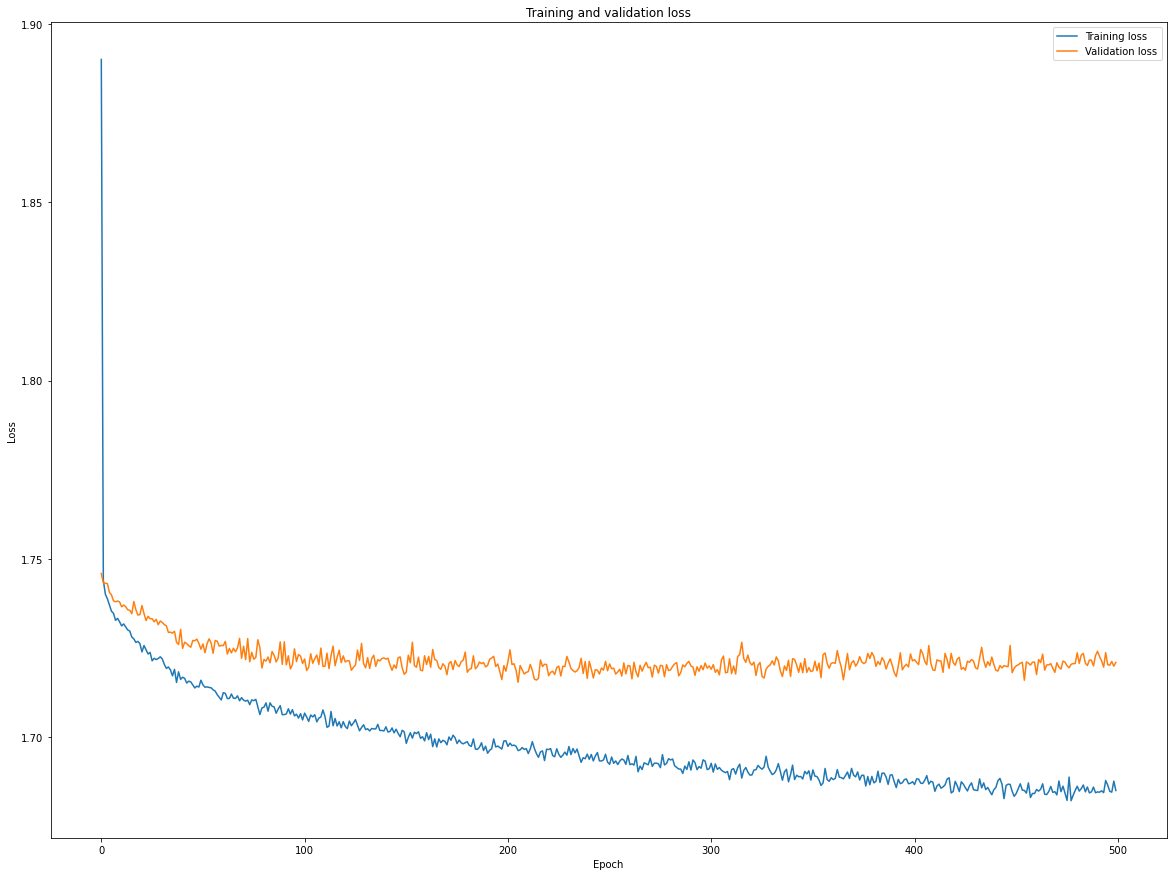

In [ ]:
model.load_state_dict(best_model_params)

# Test the neural network
model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

print('Test loss: %.4f' % (total_loss / len(test_loader)))

# Plot the training and validation losses
plt.figure(figsize=(20, 15))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Load the best model parameters
model.load_state_dict(best_model_params)
model.eval()
with torch.no_grad():
    total_loss = 0
    all_predictions = []
    all_targets = []
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        all_predictions.append(outputs.argmax(dim=1))
        all_targets.append(targets)

# Calculate accuracy
predictions = torch.cat(all_predictions).cpu().numpy()
targets = torch.cat(all_targets).cpu().numpy()
accuracy = np.mean(predictions == targets)

print('Test loss: %.4f' % (total_loss / len(test_loader)))
print('Accuracy: %.4f' % accuracy)

Test loss: 1.7128
Accuracy: 0.7443


# Evaluating probabilities with death events

In [ ]:
y_test_binary_tensor = torch.from_numpy(X_test_binary.values).to(device)

test_dataset = TensorDataset(X_test_tensor, y_test_binary_tensor)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from sklearn.metrics import recall_score, f1_score

# Load the best model parameters
model.load_state_dict(best_model_params)
model.eval()

thresholds = list(range(10))
recall_values = []

with torch.no_grad():
    total_loss = 0
    all_predictions = []
    all_targets = []
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        # Convert model predictions to binary targets
        binary_predictions = (outputs.argmax(dim=1) > 2).float()

        all_predictions.append(binary_predictions)
        all_targets.append(targets)

# Calculate accuracy
predictions = torch.cat(all_predictions).cpu().numpy()
targets = torch.cat(all_targets).cpu().numpy()
accuracy = np.mean(predictions == targets)

# Calculate recall and F1 score
recall_0 = recall_score(targets, predictions, pos_label=0)
recall_1 = recall_score(targets, predictions, pos_label=1)
f1_0 = f1_score(targets, predictions, pos_label=0)
f1_1 = f1_score(targets, predictions, pos_label=1)

print('Test loss: %.4f' % (total_loss / len(test_loader)))
print('Accuracy: %.4f' % accuracy)
print('Recall (0): %.4f' % recall_0)
print('Recall (1): %.4f' % recall_1)
print('F1 score (0): %.4f' % f1_0)
print('F1 score (1): %.4f' % f1_1)

Test loss: 1.6427
Accuracy: 0.9086
Recall (0): 0.9774
Recall (1): 0.2544
F1 score (0): 0.9508
F1 score (1): 0.3463


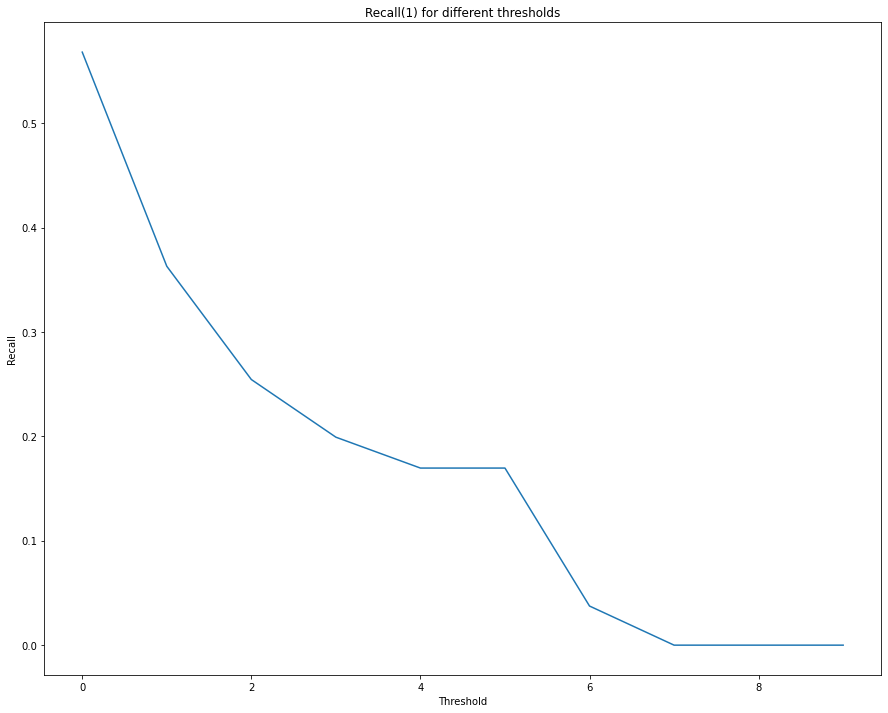

In [ ]:
from sklearn.metrics import recall_score, f1_score

# Load the best model parameters
model.load_state_dict(best_model_params)
model.eval()

thresholds = list(range(10))
thresholds_binary_predictions = [list() for i in range(10)]
recall_values = []

with torch.no_grad():
    total_loss = 0
    all_predictions = []
    all_targets = []
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        # Convert model predictions to binary targets
        for threshold in thresholds:
            binary_predictions = (outputs.argmax(dim=1) > threshold).float()
            thresholds_binary_predictions[threshold].append(binary_predictions)

        all_targets.append(targets)

# Calculate accuracy
targets = torch.cat(all_targets).cpu().numpy()

for threshold in thresholds:
    predictions = torch.cat(thresholds_binary_predictions[threshold]).cpu().numpy()
    recall_values.append(recall_score(targets, predictions, pos_label=1))

# Plot recall values against thresholds
plt.figure(figsize=(15, 12))
plt.plot(thresholds, recall_values)
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall(1) for different thresholds')
plt.show()